In [ ]:
# Only run once!!
import os

os.chdir("../src/")

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.animation as animation
from IPython.display import HTML

# from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.linear_model import LinearRegression

from models import NNModel, LeastSquaresModel
from eval import read_run_dir, get_model_from_run
from tasks import Polynomials, PolynomialsFactorForm, FourierSeries
from samplers import get_data_sampler
from tasks import get_task_sampler

%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")
mpl.rcParams["figure.dpi"] = 300

sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["text.usetex"] = True

mpl.rcParams.update(
    {
        "axes.titlesize": 12,
        "figure.titlesize": 10,  # was 10
        "legend.fontsize": 10,  # was 10
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SPINE_COLOR = "gray"


def format_axes(ax):
    for spine in ["top", "right"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction="out", color=SPINE_COLOR)
    return ax

In [4]:
task = "fourier_series"

run_path = "../models/fourier_series_mixture/final_model"
model, conf = get_model_from_run(run_path)


n_dims = conf.model.n_dims
batch_size = 1280  # conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims, **conf.training.data_kwargs)
task_sampler = get_task_sampler(
    conf.training.task, n_dims, batch_size, **conf.training.task_kwargs
)

In [5]:
# torch.manual_seed(42)
# task = task_sampler()
# xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
# # xs = torch.tensor([list(np.linspace(-2, 2, 20).tolist()) for _ in range(batch_size)]).unsqueeze(-1)
# task = Four
# ys = task.evaluate(xs)

In [6]:
class FourierFeatures:
    def __init__(self, max_freq, L):
        self.max_freq = max_freq
        self.L = L

    def transform(self, x):
        # Currently on supports 1-d features
        assert x.shape[-1] == 1
        batch_size = x.shape[0]
        sine_features = torch.sin(
            (math.pi / (self.L))
            * torch.arange(1, self.max_freq + 1).unsqueeze(0)
            * x.view(-1, 1)
        ).view(batch_size, -1, self.max_freq)
        cosine_features = torch.cos(
            (math.pi / (self.L))
            * torch.arange(1, self.max_freq + 1).unsqueeze(0)
            * x.view(-1, 1)
        ).view(batch_size, -1, self.max_freq)

        return torch.cat([sine_features, cosine_features], dim=-1)

In [7]:
class FourierBMA:
    def __init__(self, max_freq, L):
        self.max_freq = max_freq
        self.L = L

        self.models = [
            LinearRegression(fit_intercept=False) for _ in range(self.max_freq)
        ]

    def fit(self, X, y):
        bma_weights = np.zeros(2 * self.max_freq)
        a_n = np.zeros(self.max_freq)
        b_n = np.zeros(self.max_freq)
        for i, freq in enumerate(range(1, self.max_freq + 1)):
            model = self.models[i]
            features = (
                FourierFeatures(freq, self.L)
                .transform(X.unsqueeze(1))
                .squeeze(1)
                .numpy()
            )
            model.fit(features, y)
            weights = model.coef_
            a_d = weights[: len(weights) // 2]
            b_d = weights[len(weights) // 2 :]

            a_d = np.pad(a_d, pad_width=(0, self.max_freq - freq))
            b_d = np.pad(b_d, pad_width=(0, self.max_freq - freq))
            a_n += a_d
            b_n += b_d

        self.bma_weights = (np.concatenate([a_n, b_n], axis=0)) / (self.max_freq)

    def predict(self, X):
        features = (
            FourierFeatures(self.max_freq, self.L)
            .transform(X.unsqueeze(1))
            .squeeze(1)
            .numpy()
        )

        return features @ self.bma_weights[:, None]

In [8]:
class FourierBMARidge:
    def __init__(self, max_freq, L):
        self.max_freq = max_freq
        self.L = L

        self.models = [RidgeCV(fit_intercept=False) for _ in range(self.max_freq)]

    def fit(self, X, y):
        bma_weights = np.zeros(2 * self.max_freq)
        a_n = np.zeros(self.max_freq)
        b_n = np.zeros(self.max_freq)
        for i, freq in enumerate(range(1, self.max_freq + 1)):
            model = self.models[i]
            features = (
                FourierFeatures(freq, self.L)
                .transform(X.unsqueeze(1))
                .squeeze(1)
                .numpy()
            )
            model.fit(features, y)
            weights = model.coef_
            a_d = weights[: len(weights) // 2]
            b_d = weights[len(weights) // 2 :]

            a_d = np.pad(a_d, pad_width=(0, self.max_freq - freq))
            b_d = np.pad(b_d, pad_width=(0, self.max_freq - freq))
            a_n += a_d
            b_n += b_d

        self.bma_weights = (np.concatenate([a_n, b_n], axis=0)) / (self.max_freq)

    def predict(self, X):
        features = (
            FourierFeatures(self.max_freq, self.L)
            .transform(X.unsqueeze(1))
            .squeeze(1)
            .numpy()
        )

        return features @ self.bma_weights[:, None]

In [9]:
conf.training.curriculum.points.end

40

In [10]:
def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, seed):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        seed=seed,
        ci=90,
    )

In [11]:
min_frequency

NameError: name 'min_frequency' is not defined

In [12]:
import warnings

warnings.filterwarnings("ignore")

torch.manual_seed(42)

batch_size = 128
L = conf.training.task_kwargs["L"]
max_frequency = conf.training.task_kwargs["max_frequency"]
model.to("cuda")
n = conf.training.curriculum.points.end
max_frequency, min_frequency = (
    conf.training.task_kwargs["max_frequency"],
    conf.training.task_kwargs["min_frequency"],
)

trans_errors_ls = []
ffg_errors_ls = []
ffm_errors_ls = []
bma_errors_ls = []
for max_freq in tqdm(range(1, 11)):
    task = FourierSeries(
        1,
        batch_size,
        min_frequency=max_freq,
        max_frequency=max_freq,
        standardize=True,
        L=L,
    )
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=n)
    ys = task.evaluate(xs)

    print("Fitting OLS Fourier Basis Gold")
    fourier_fit_model = LeastSquaresModel()
    fourier_fit_preds = fourier_fit_model(
        torch.Tensor(FourierFeatures(max_freq=max_freq, L=L).transform(xs)), ys
    )

    print("Fitting OLS Fourier Basis Max")
    fourier_fit_max_freq_model = LeastSquaresModel()
    fourier_fit_max_freq_preds = fourier_fit_model(
        torch.Tensor(FourierFeatures(max_freq=max_frequency, L=L).transform(xs)), ys
    )

    print("Predicting With Transformer")
    with torch.no_grad():
        y_pred = model(xs.to("cuda"), ys.to("cuda")).to("cpu")

    #     print("Fitting BMA")
    #     bma_preds = []
    #     for b in range(batch_size):
    #         batch_preds = [0]
    #         for t in range(1, n):
    #             bma_model = FourierBMA(conf.training.task_kwargs["max_frequency"], L = L)
    #             bma_model.fit(xs[b, :t], ys[b, :t])
    #             batch_preds.append(bma_model.predict(xs[b,t:t+1]).squeeze())
    #         bma_preds.append(batch_preds)

    #     bma_preds = torch.tensor(bma_preds)

    metric = task.get_metric()
    sq_errors = metric(ys, y_pred)
    sq_ffg_errors = metric(
        ys,
        fourier_fit_preds,
    )
    sq_ffm_errors = metric(ys, fourier_fit_max_freq_preds)
    #     sq_bma_errors = metric(ys, bma_preds)

    trans_errors_ls.append(sq_errors)
    ffg_errors_ls.append(sq_ffg_errors)
    ffm_errors_ls.append(sq_ffm_errors)
#     bma_errors_ls.append(sq_bma_errors)

  0%|                                                                                                                                      | 0/10 [00:00<?, ?it/s]

Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max
Predicting With Transformer


 10%|████████████▌                                                                                                                 | 1/10 [00:00<00:05,  1.67it/s]

Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max
Predicting With Transformer


 20%|█████████████████████████▏                                                                                                    | 2/10 [00:00<00:03,  2.54it/s]

Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max
Predicting With Transformer


 30%|█████████████████████████████████████▊                                                                                        | 3/10 [00:01<00:02,  3.10it/s]

Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max


 40%|██████████████████████████████████████████████████▍                                                                           | 4/10 [00:01<00:01,  3.15it/s]

Predicting With Transformer
Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max


 50%|███████████████████████████████████████████████████████████████                                                               | 5/10 [00:01<00:01,  3.23it/s]

Predicting With Transformer
Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max
Predicting With Transformer


 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 6/10 [00:02<00:01,  3.03it/s]

Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max


 70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7/10 [00:02<00:00,  3.03it/s]

Predicting With Transformer
Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8/10 [00:02<00:00,  2.92it/s]

Predicting With Transformer
Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max
Predicting With Transformer


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9/10 [00:03<00:00,  2.86it/s]

Fitting OLS Fourier Basis Gold
Fitting OLS Fourier Basis Max


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]

Predicting With Transformer


In [13]:
task

In [14]:
sq_ffm_errors.max()

tensor(0.9244)

In [15]:
sq_ffg_errors.max()

tensor(0.9244)

<Figure size 1920x1440 with 0 Axes>

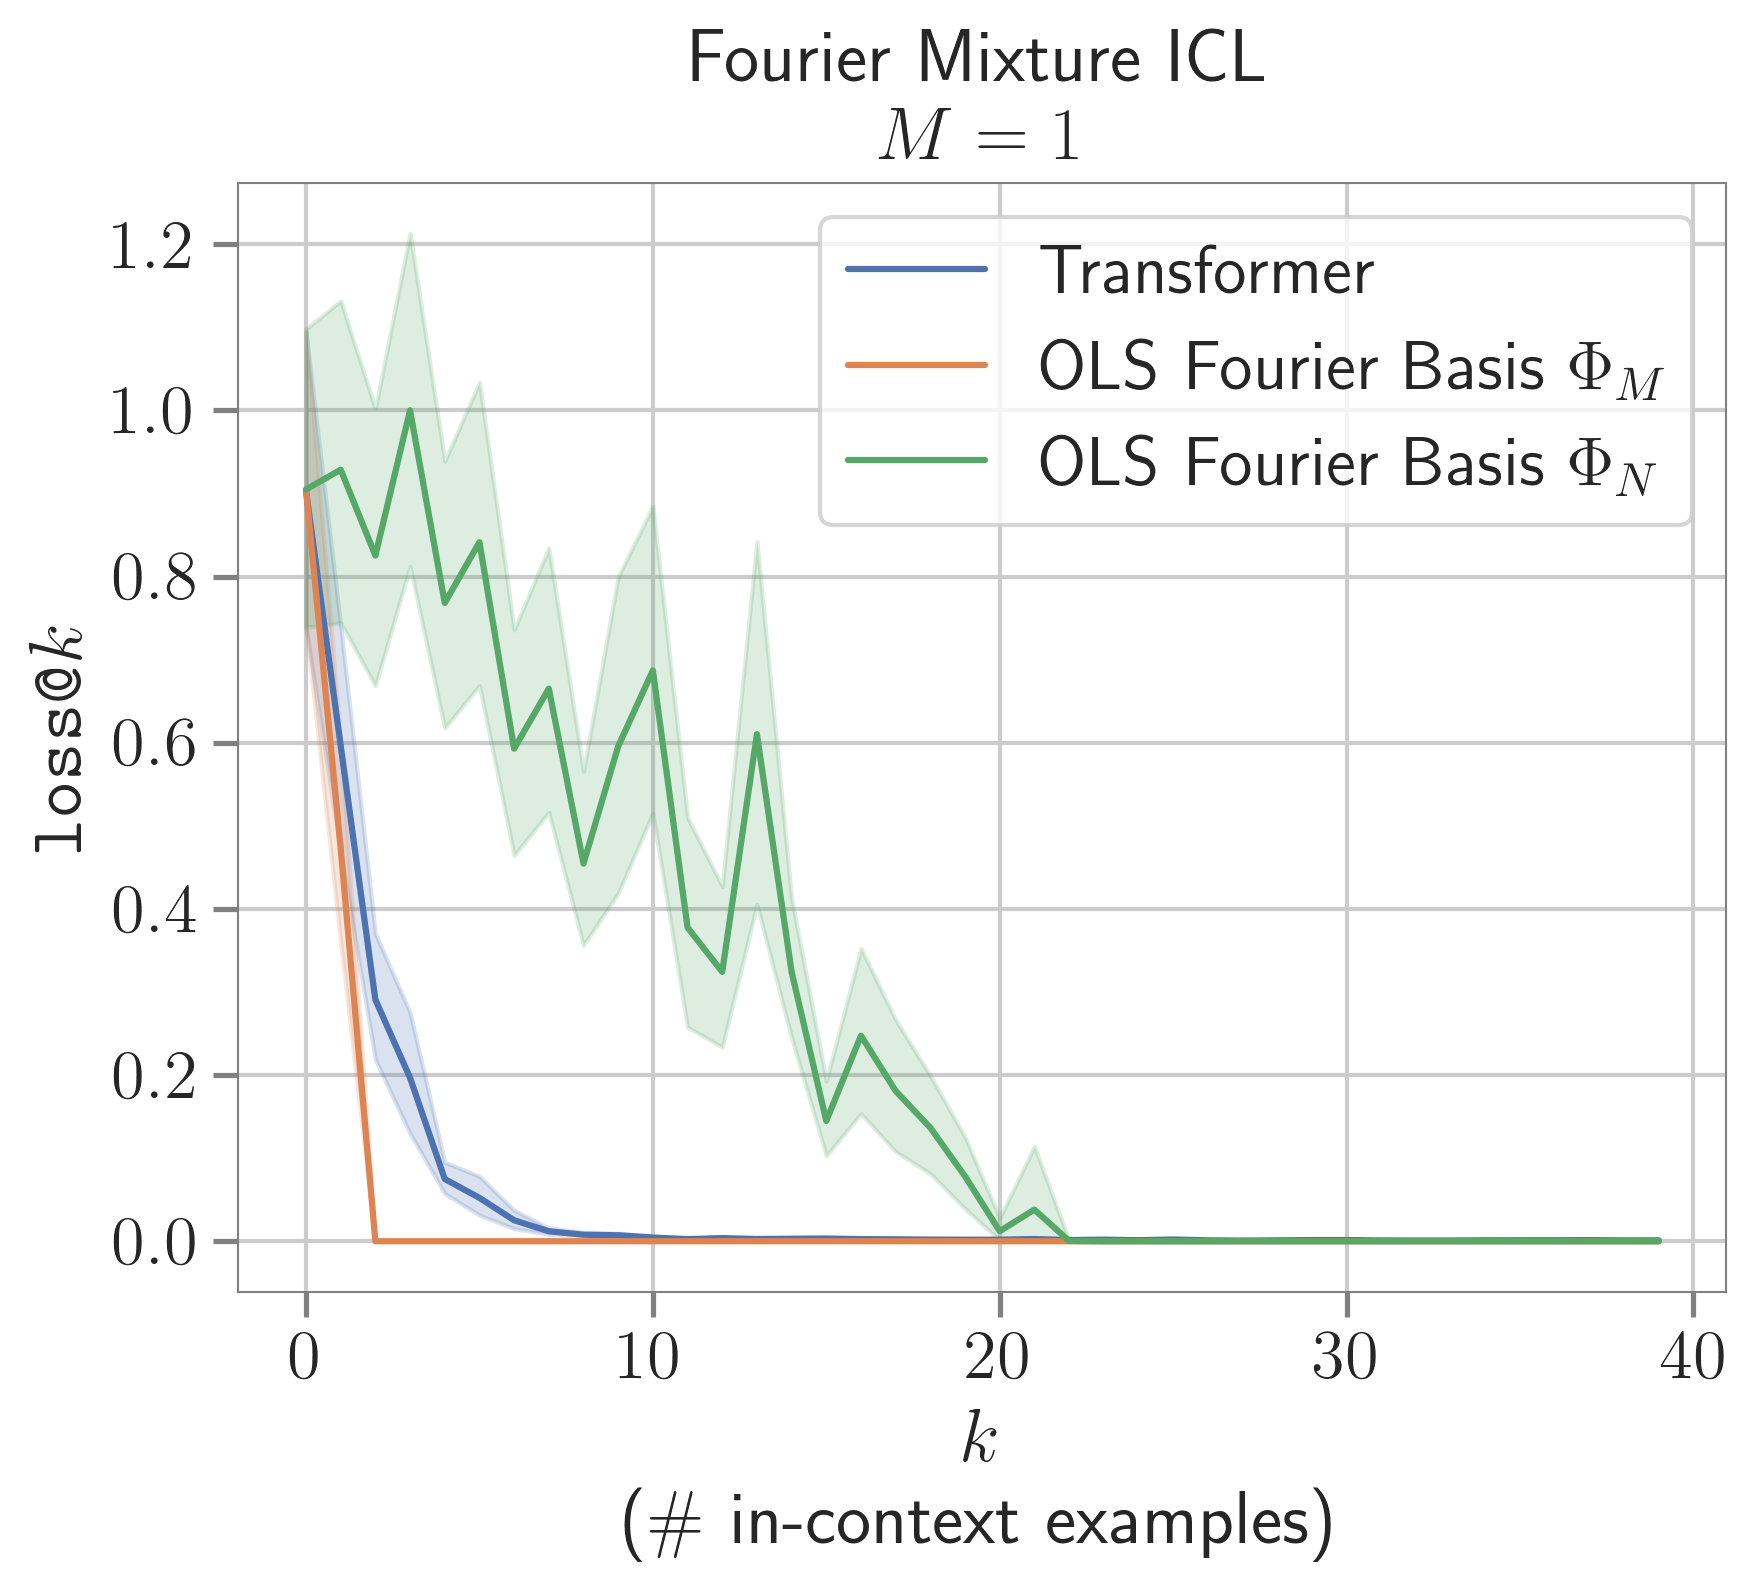

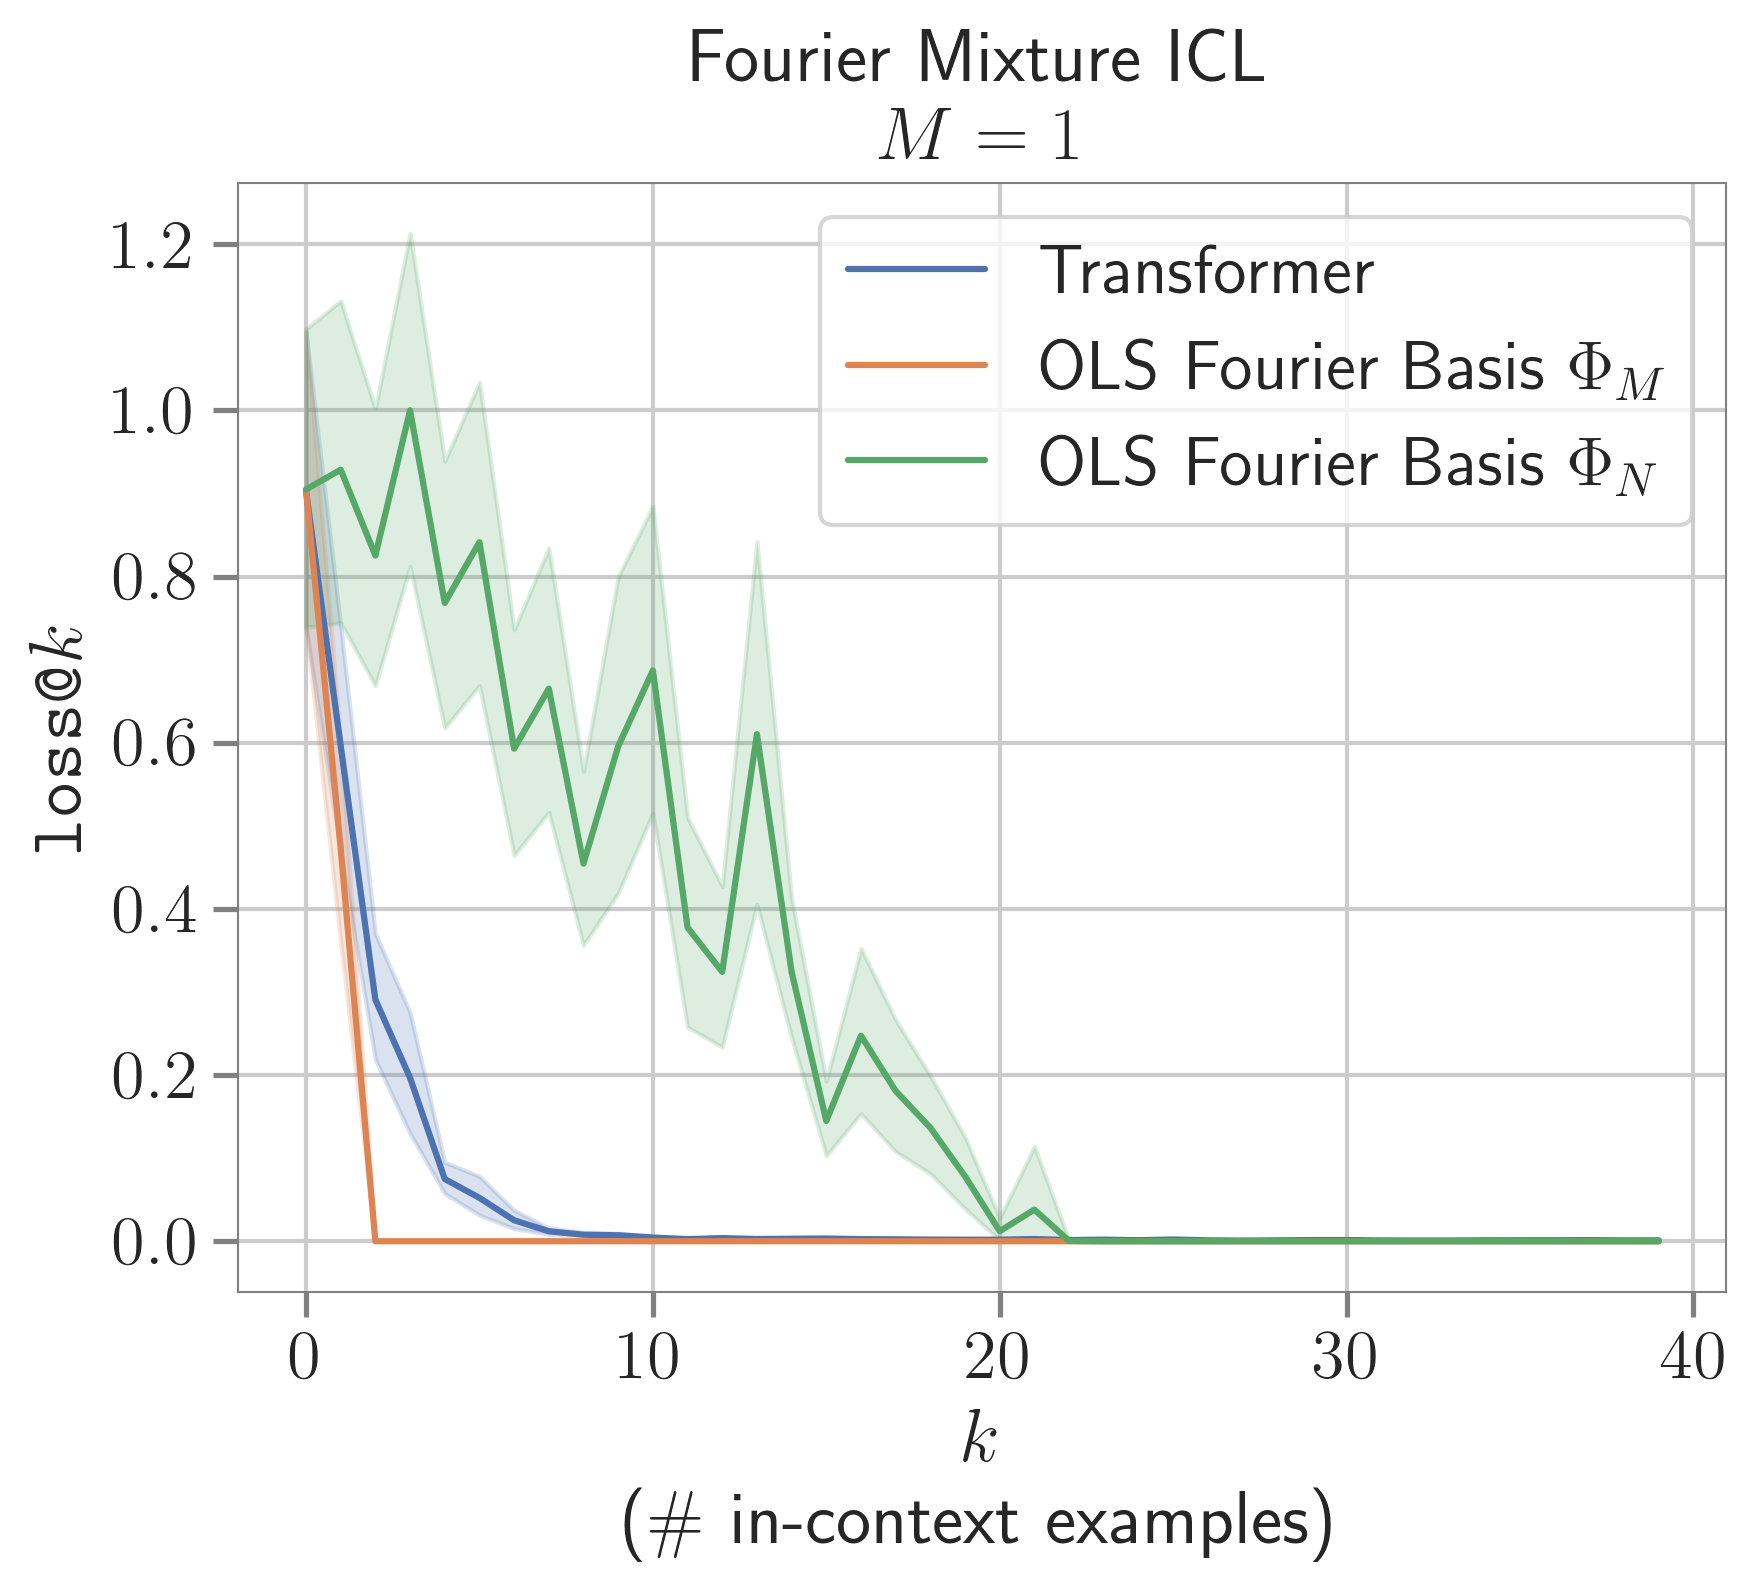

<Figure size 1920x1440 with 0 Axes>

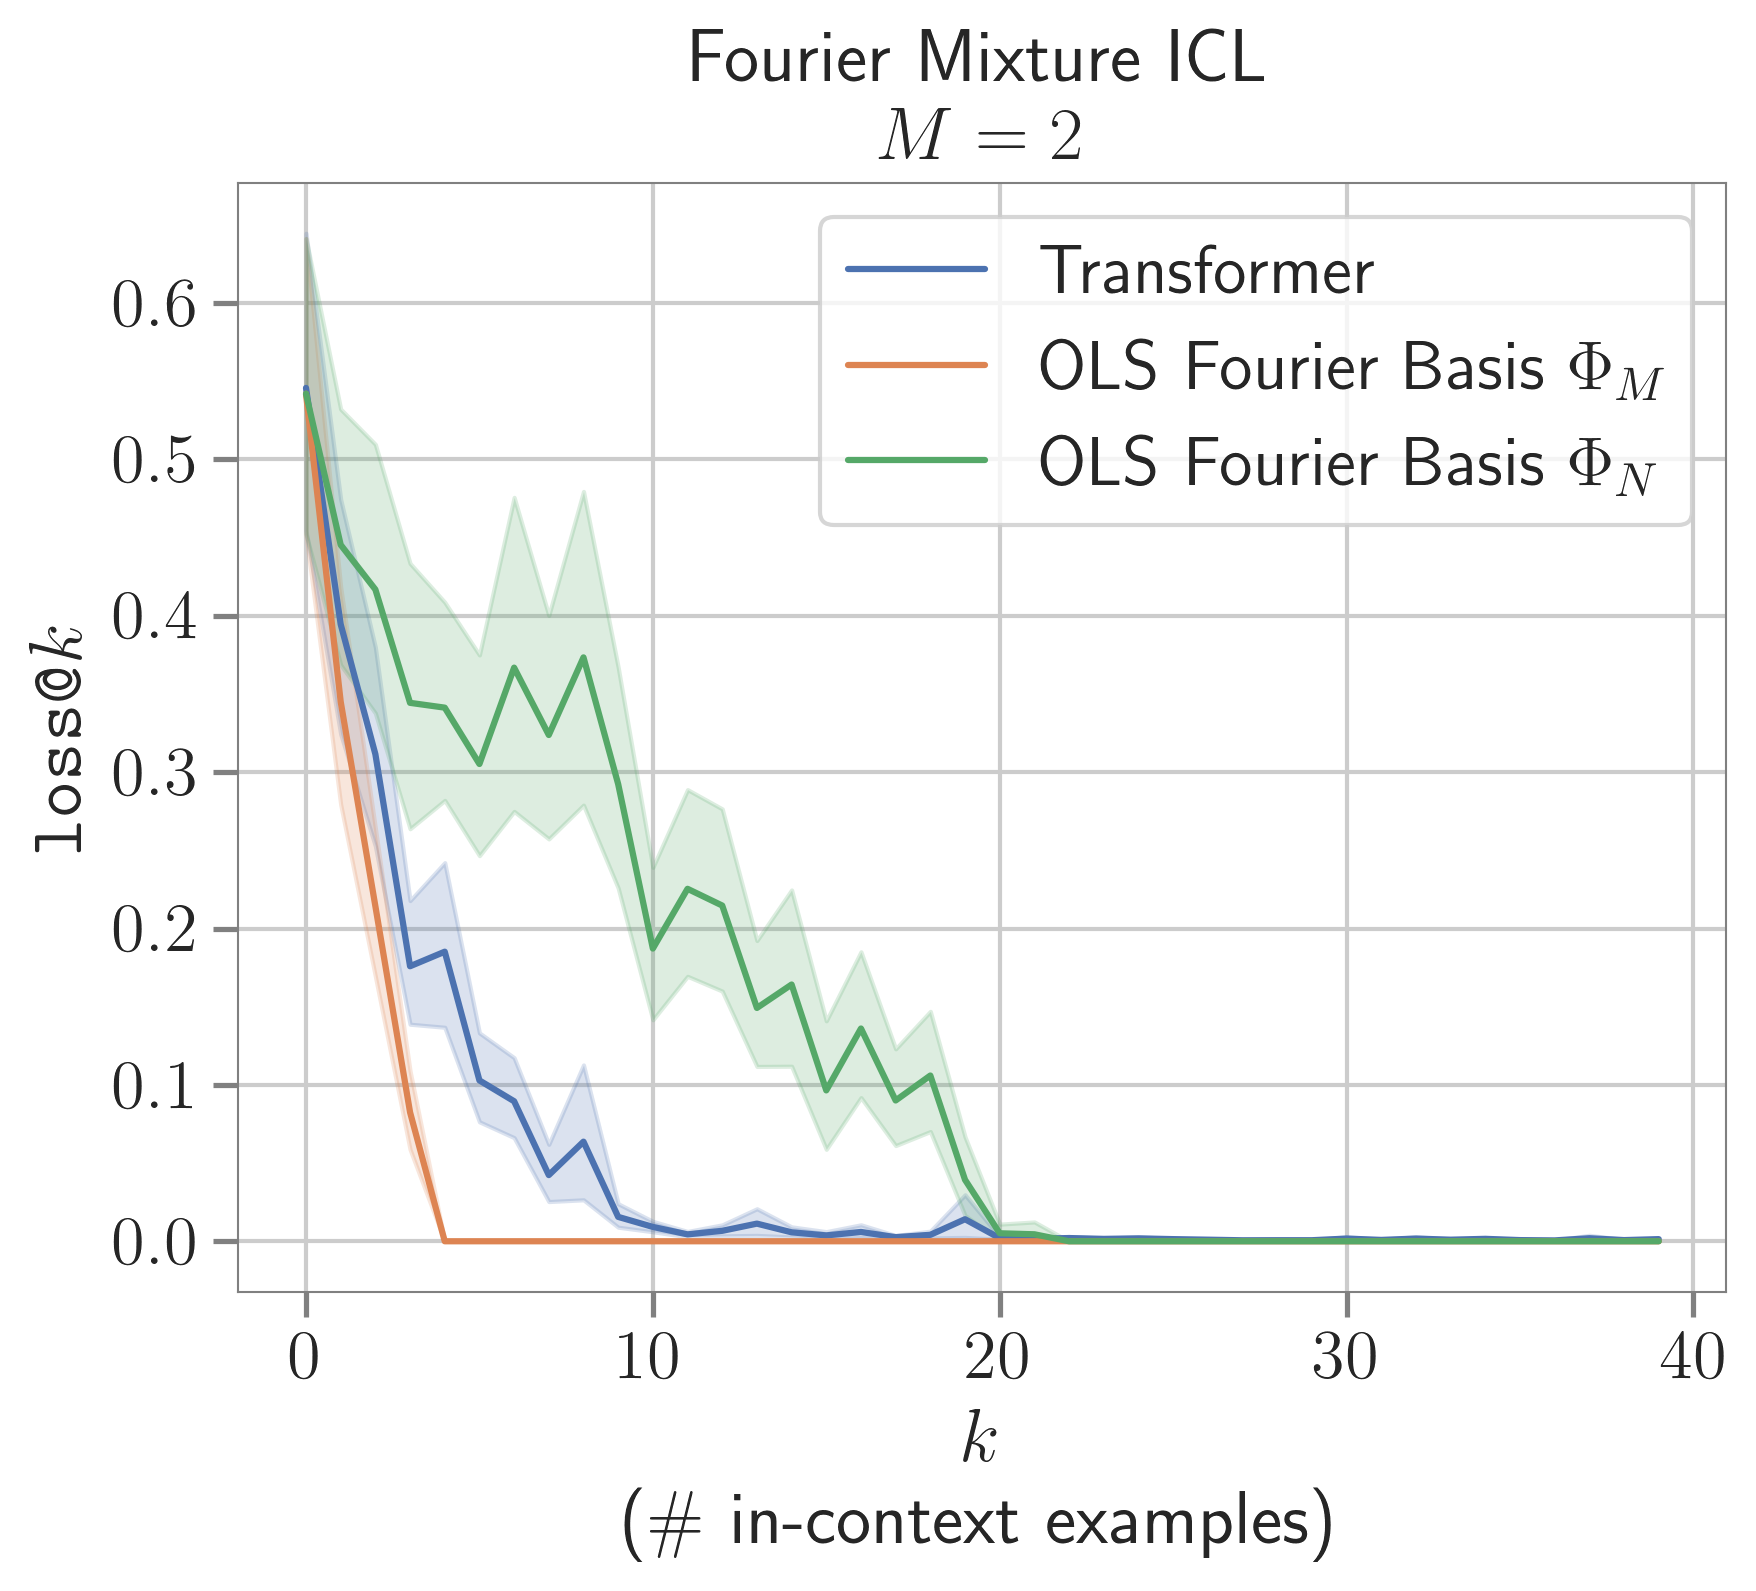

<Figure size 1920x1440 with 0 Axes>

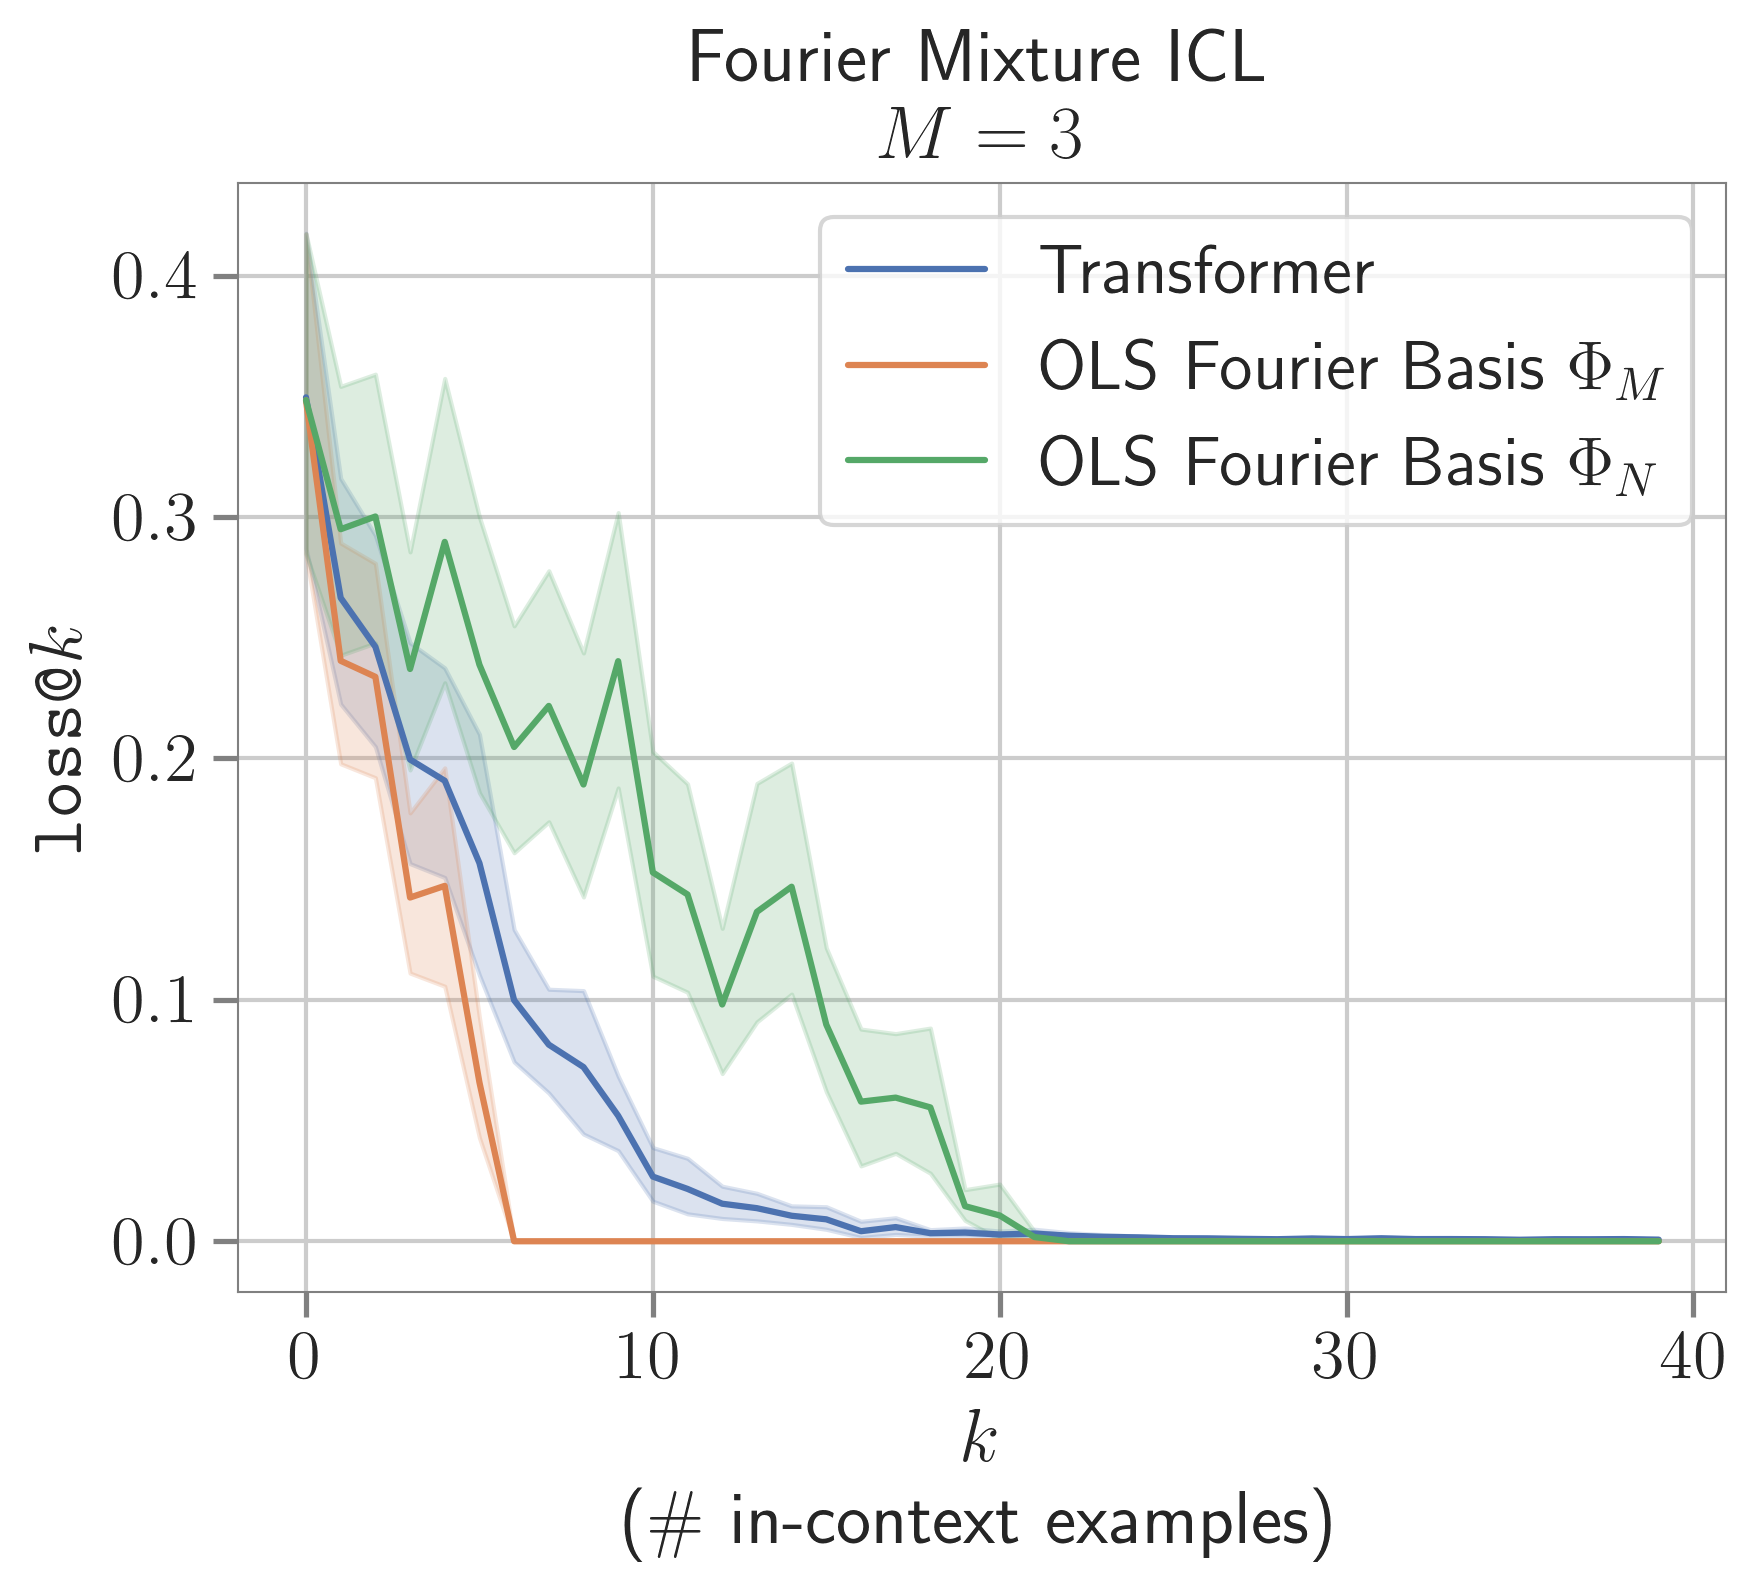

<Figure size 1920x1440 with 0 Axes>

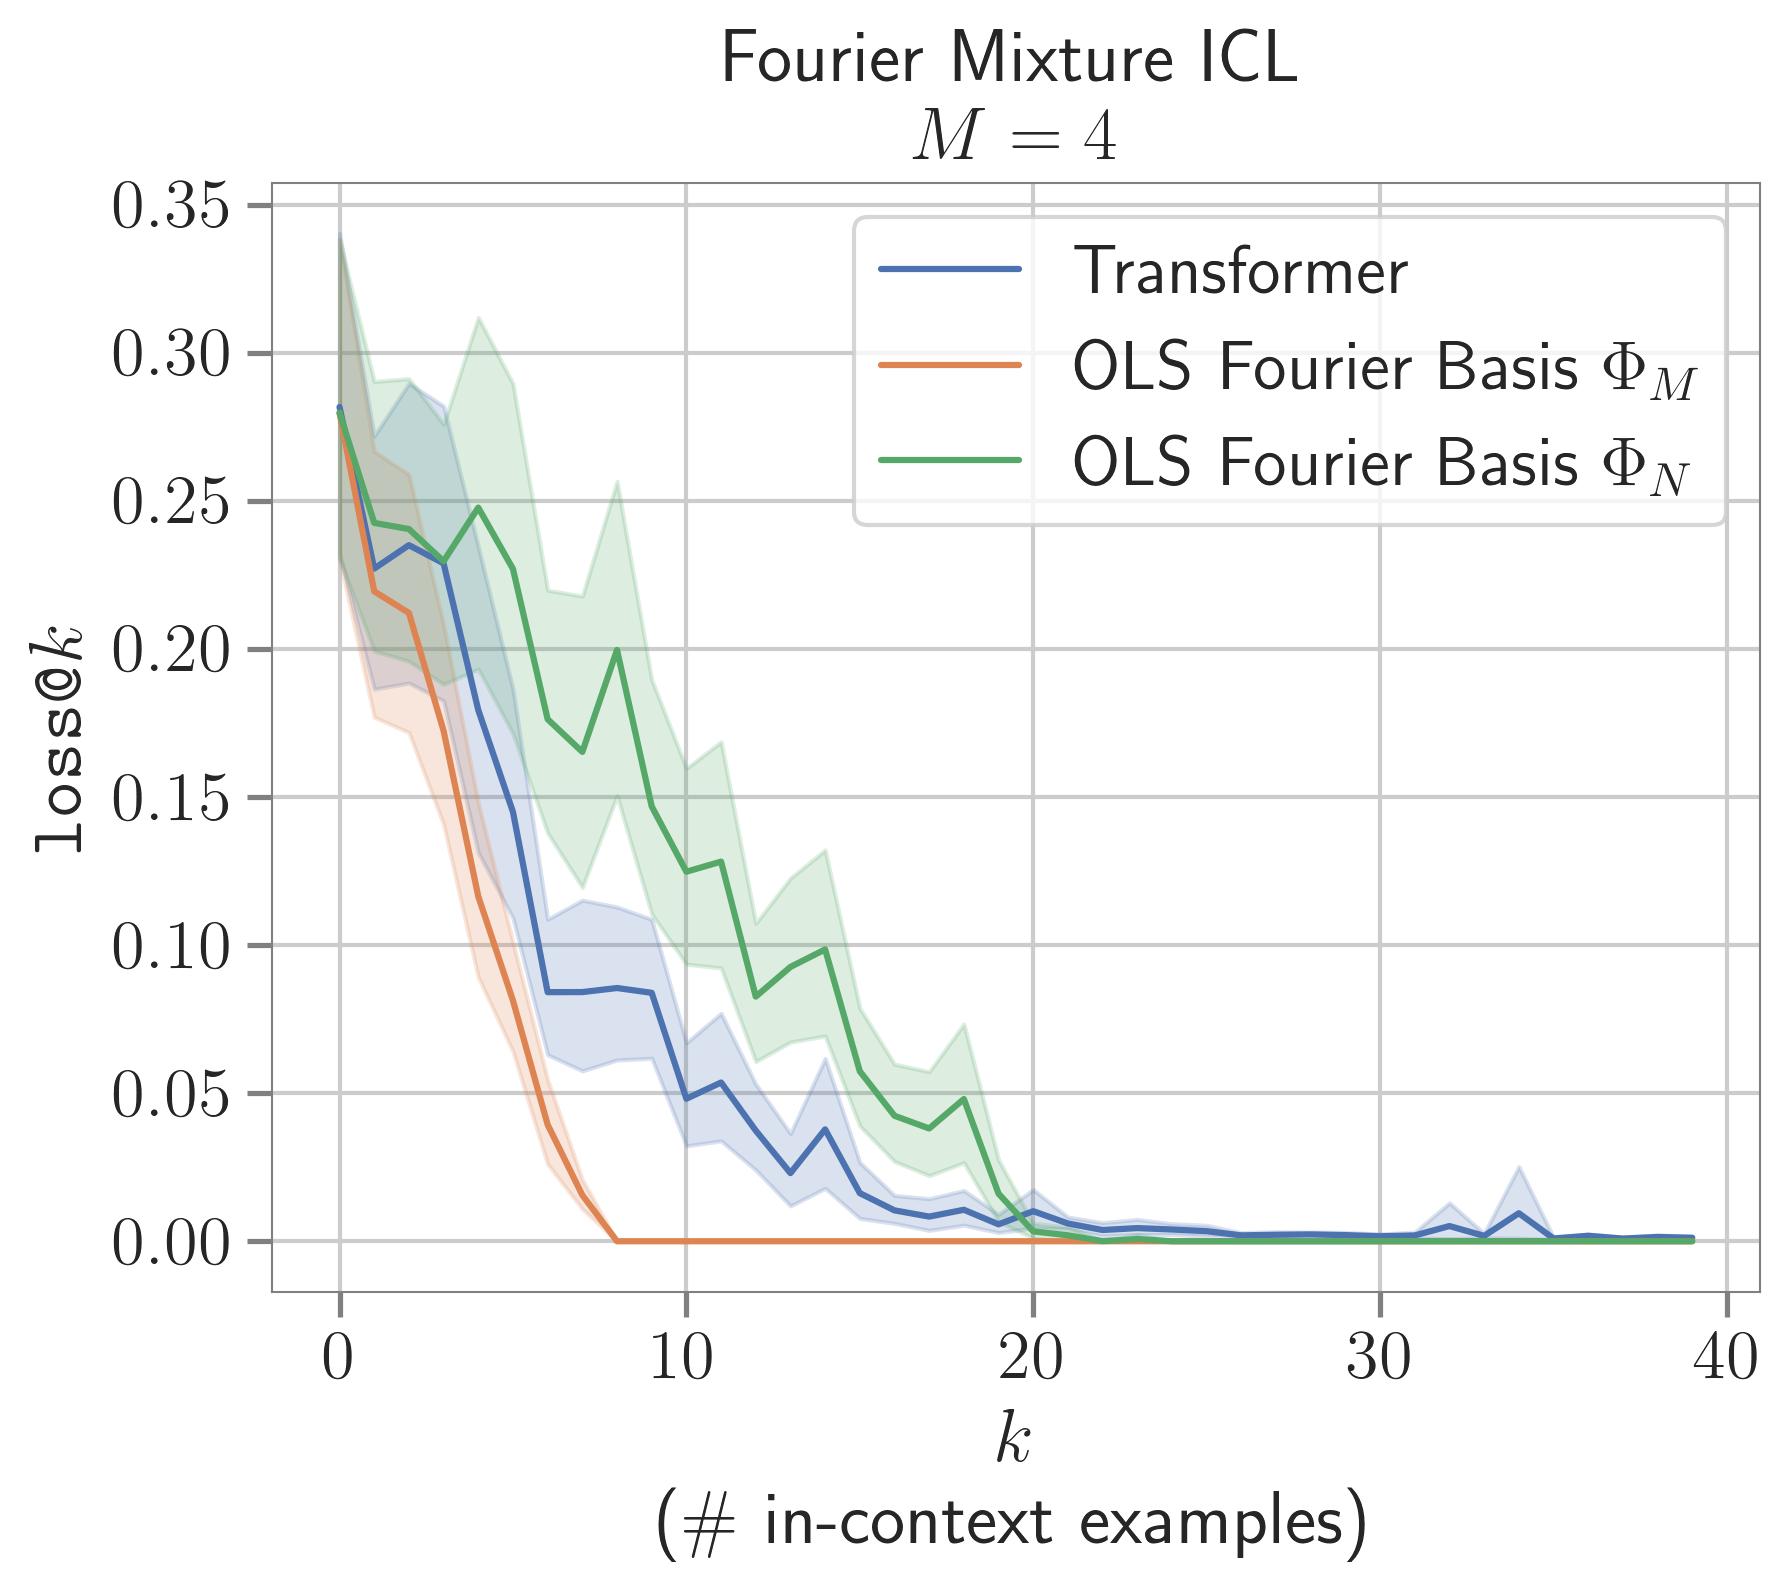

<Figure size 1920x1440 with 0 Axes>

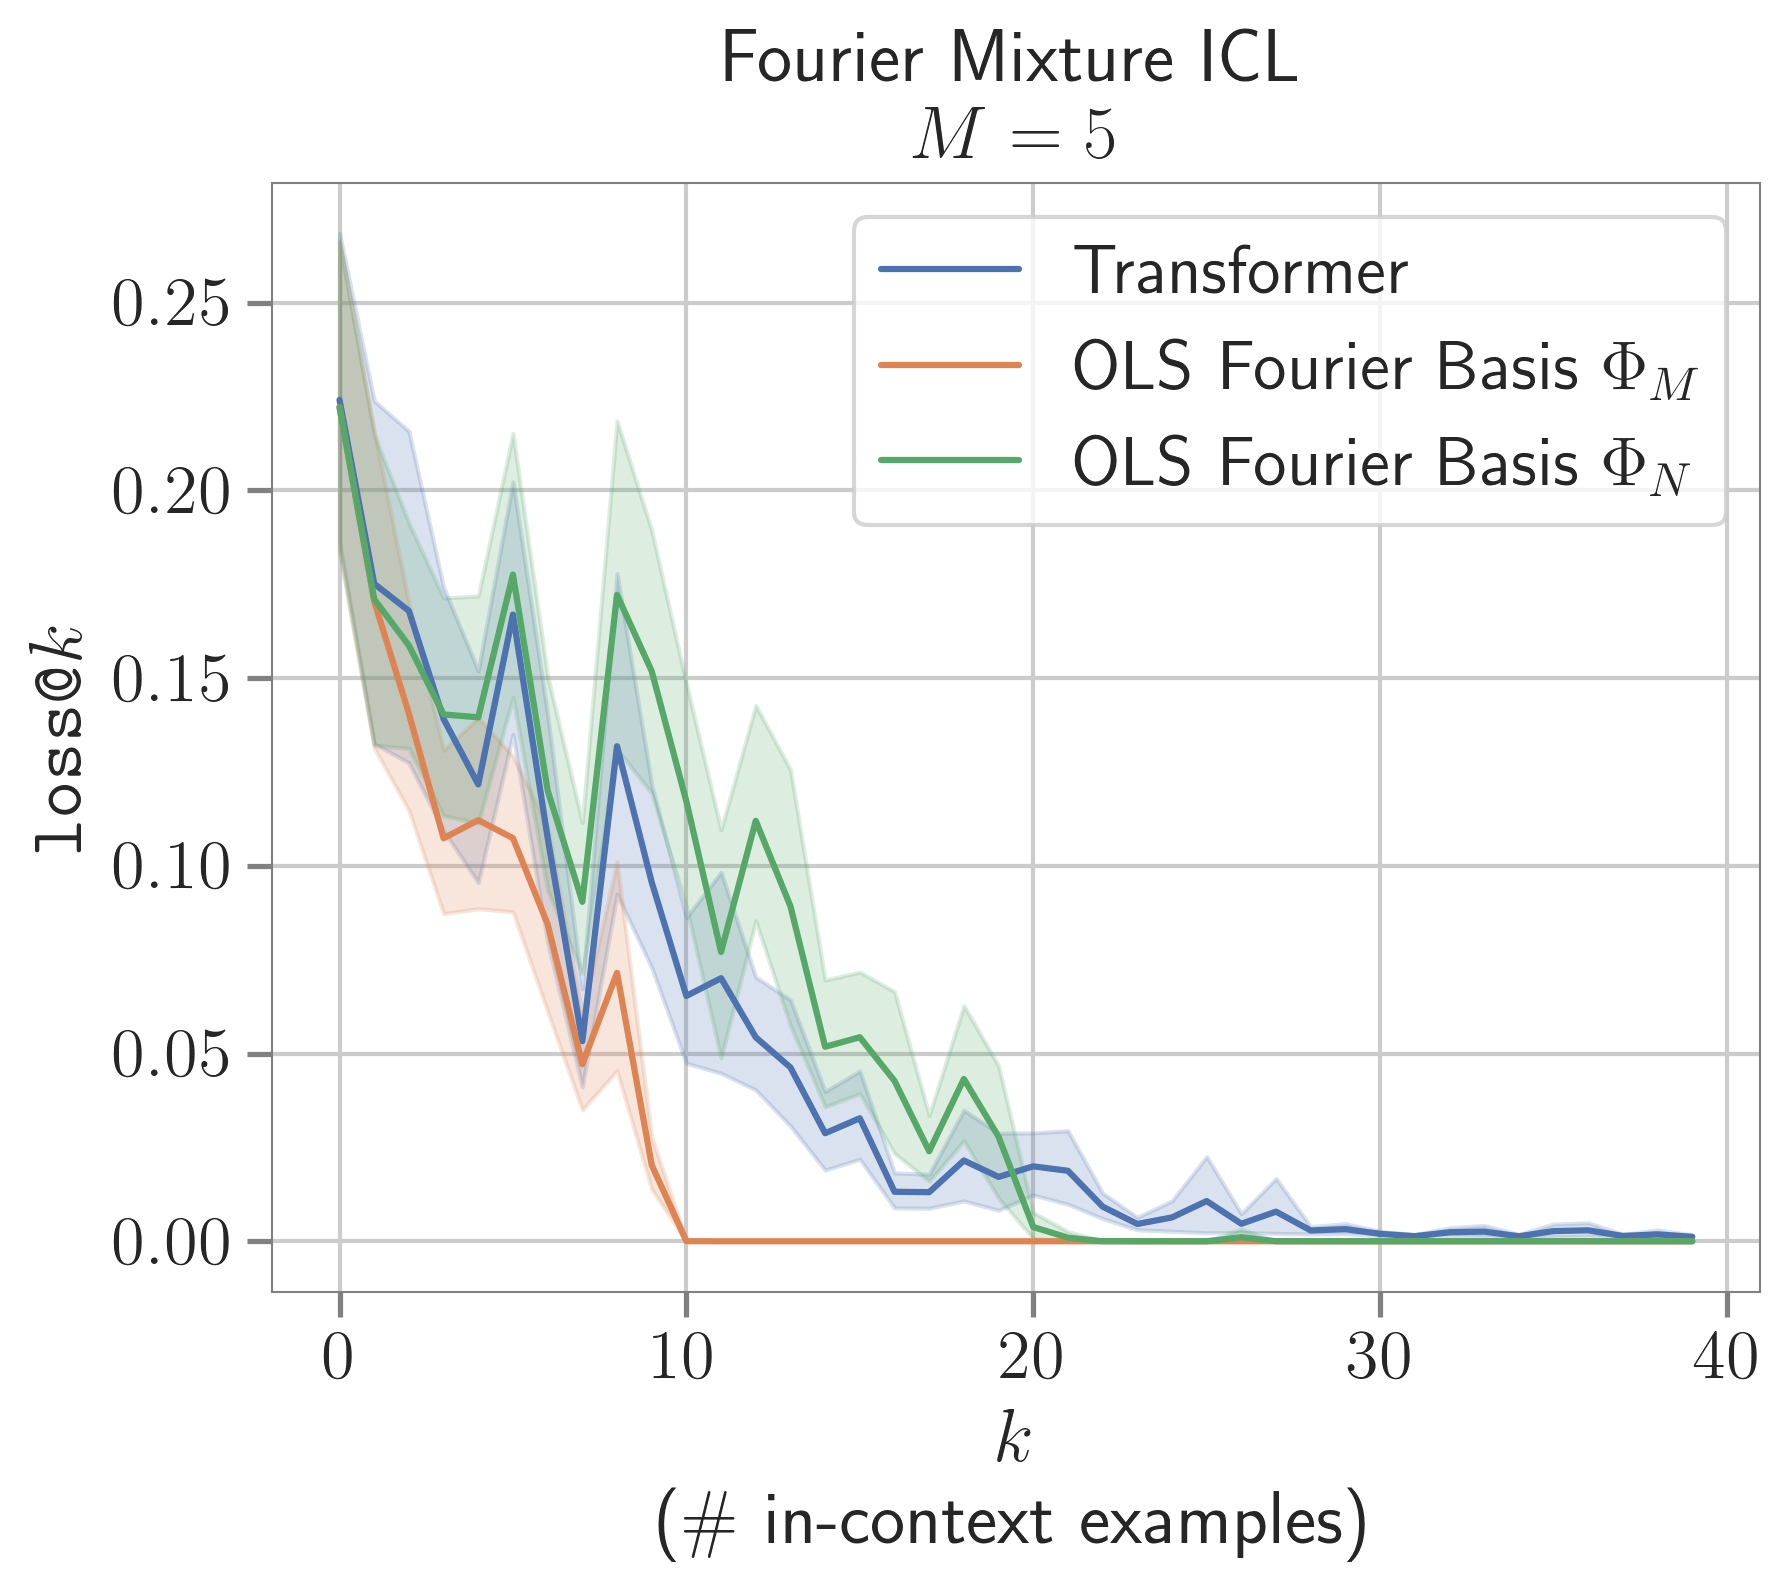

<Figure size 1920x1440 with 0 Axes>

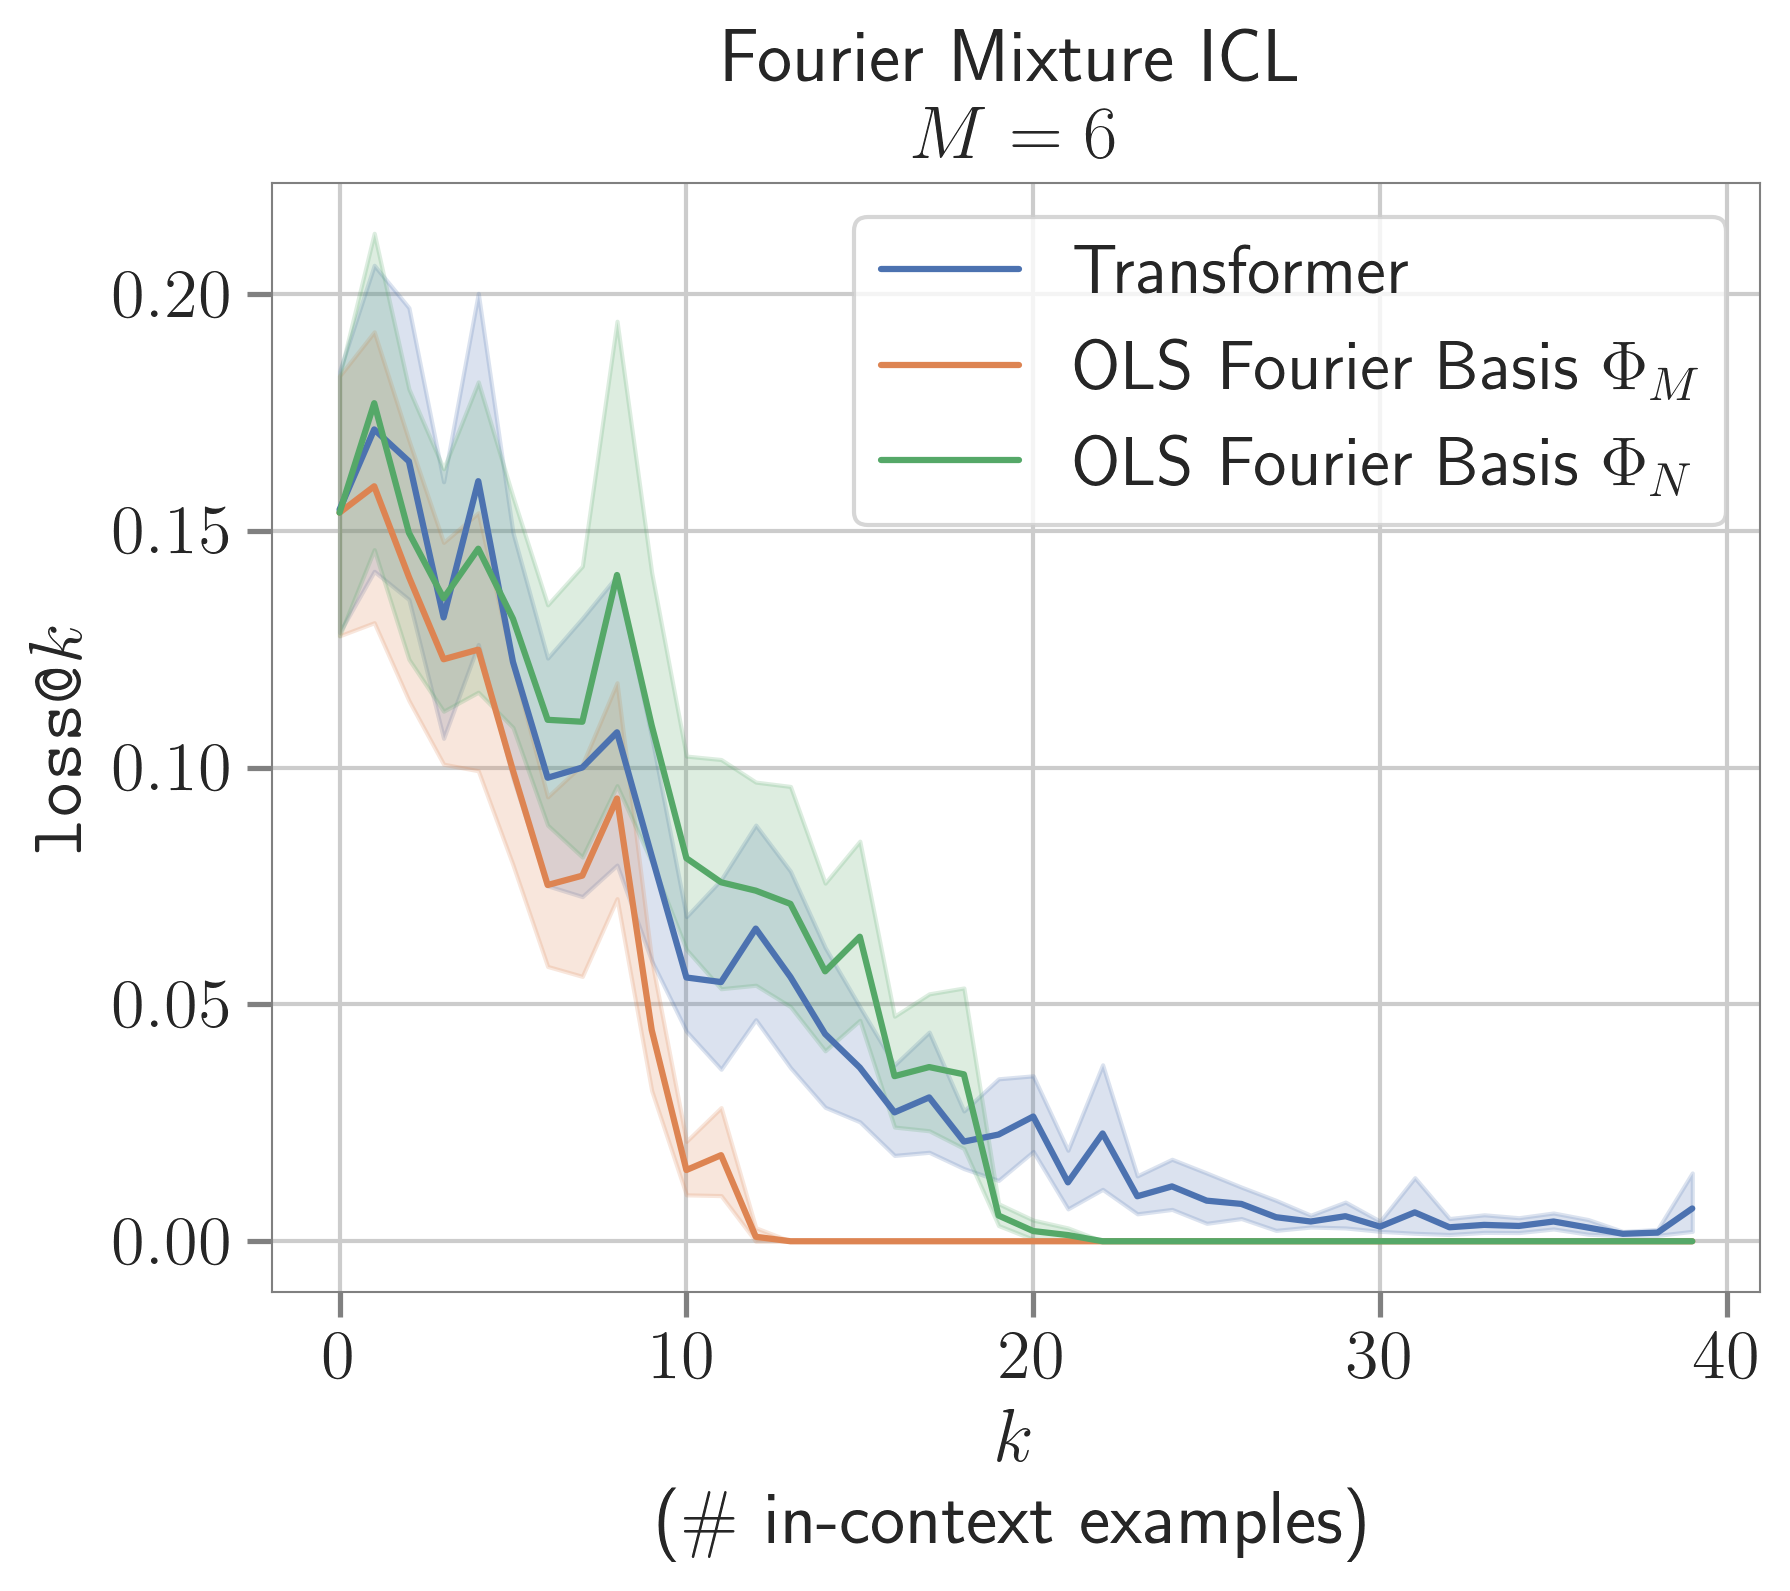

<Figure size 1920x1440 with 0 Axes>

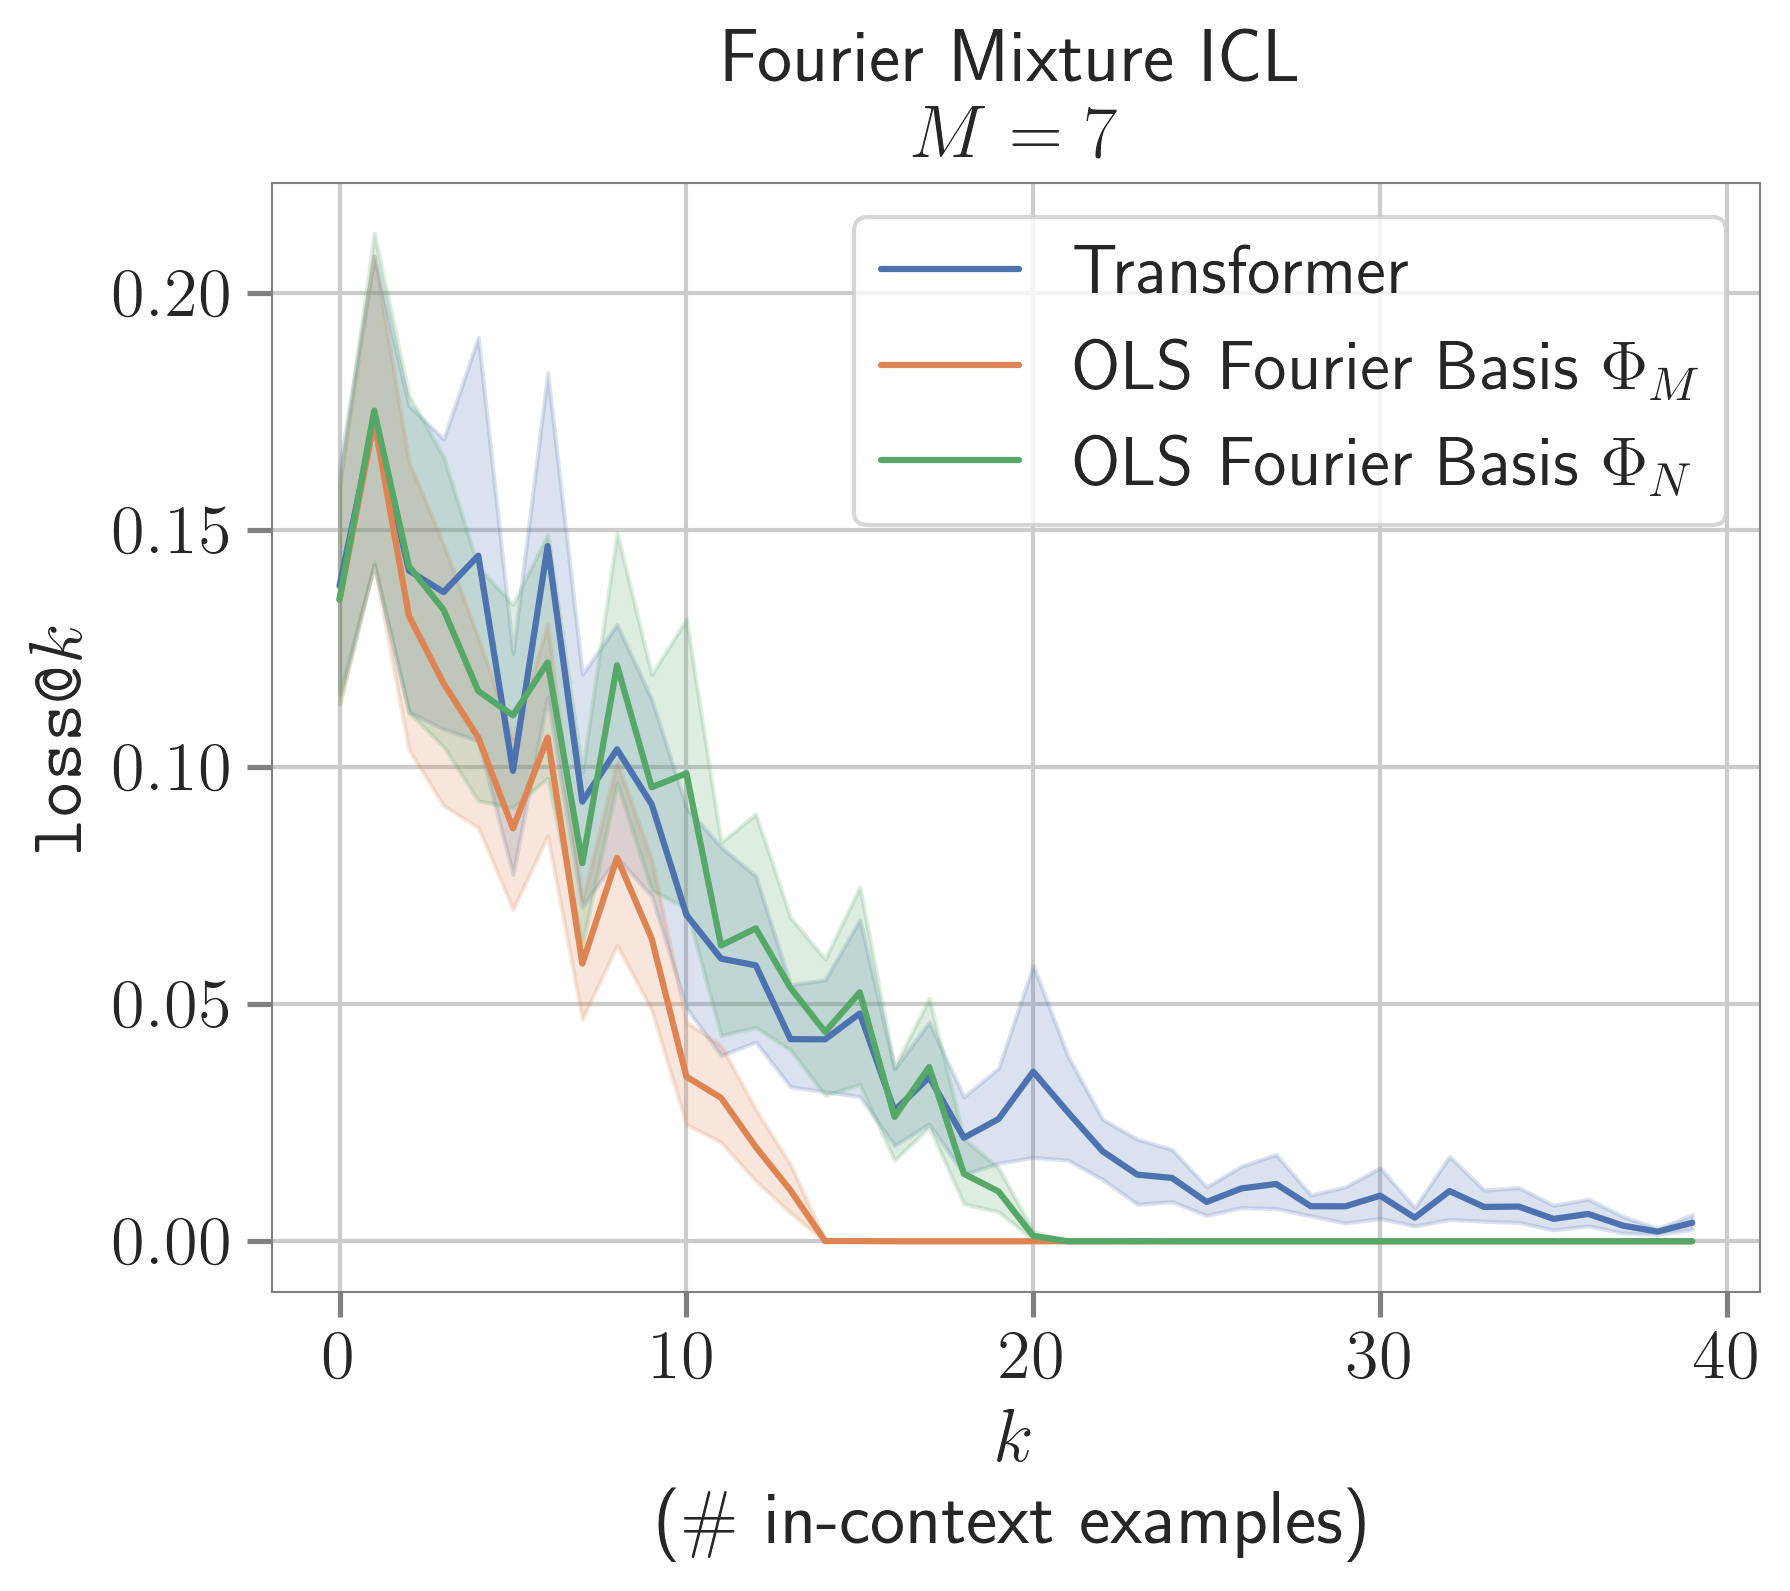

<Figure size 1920x1440 with 0 Axes>

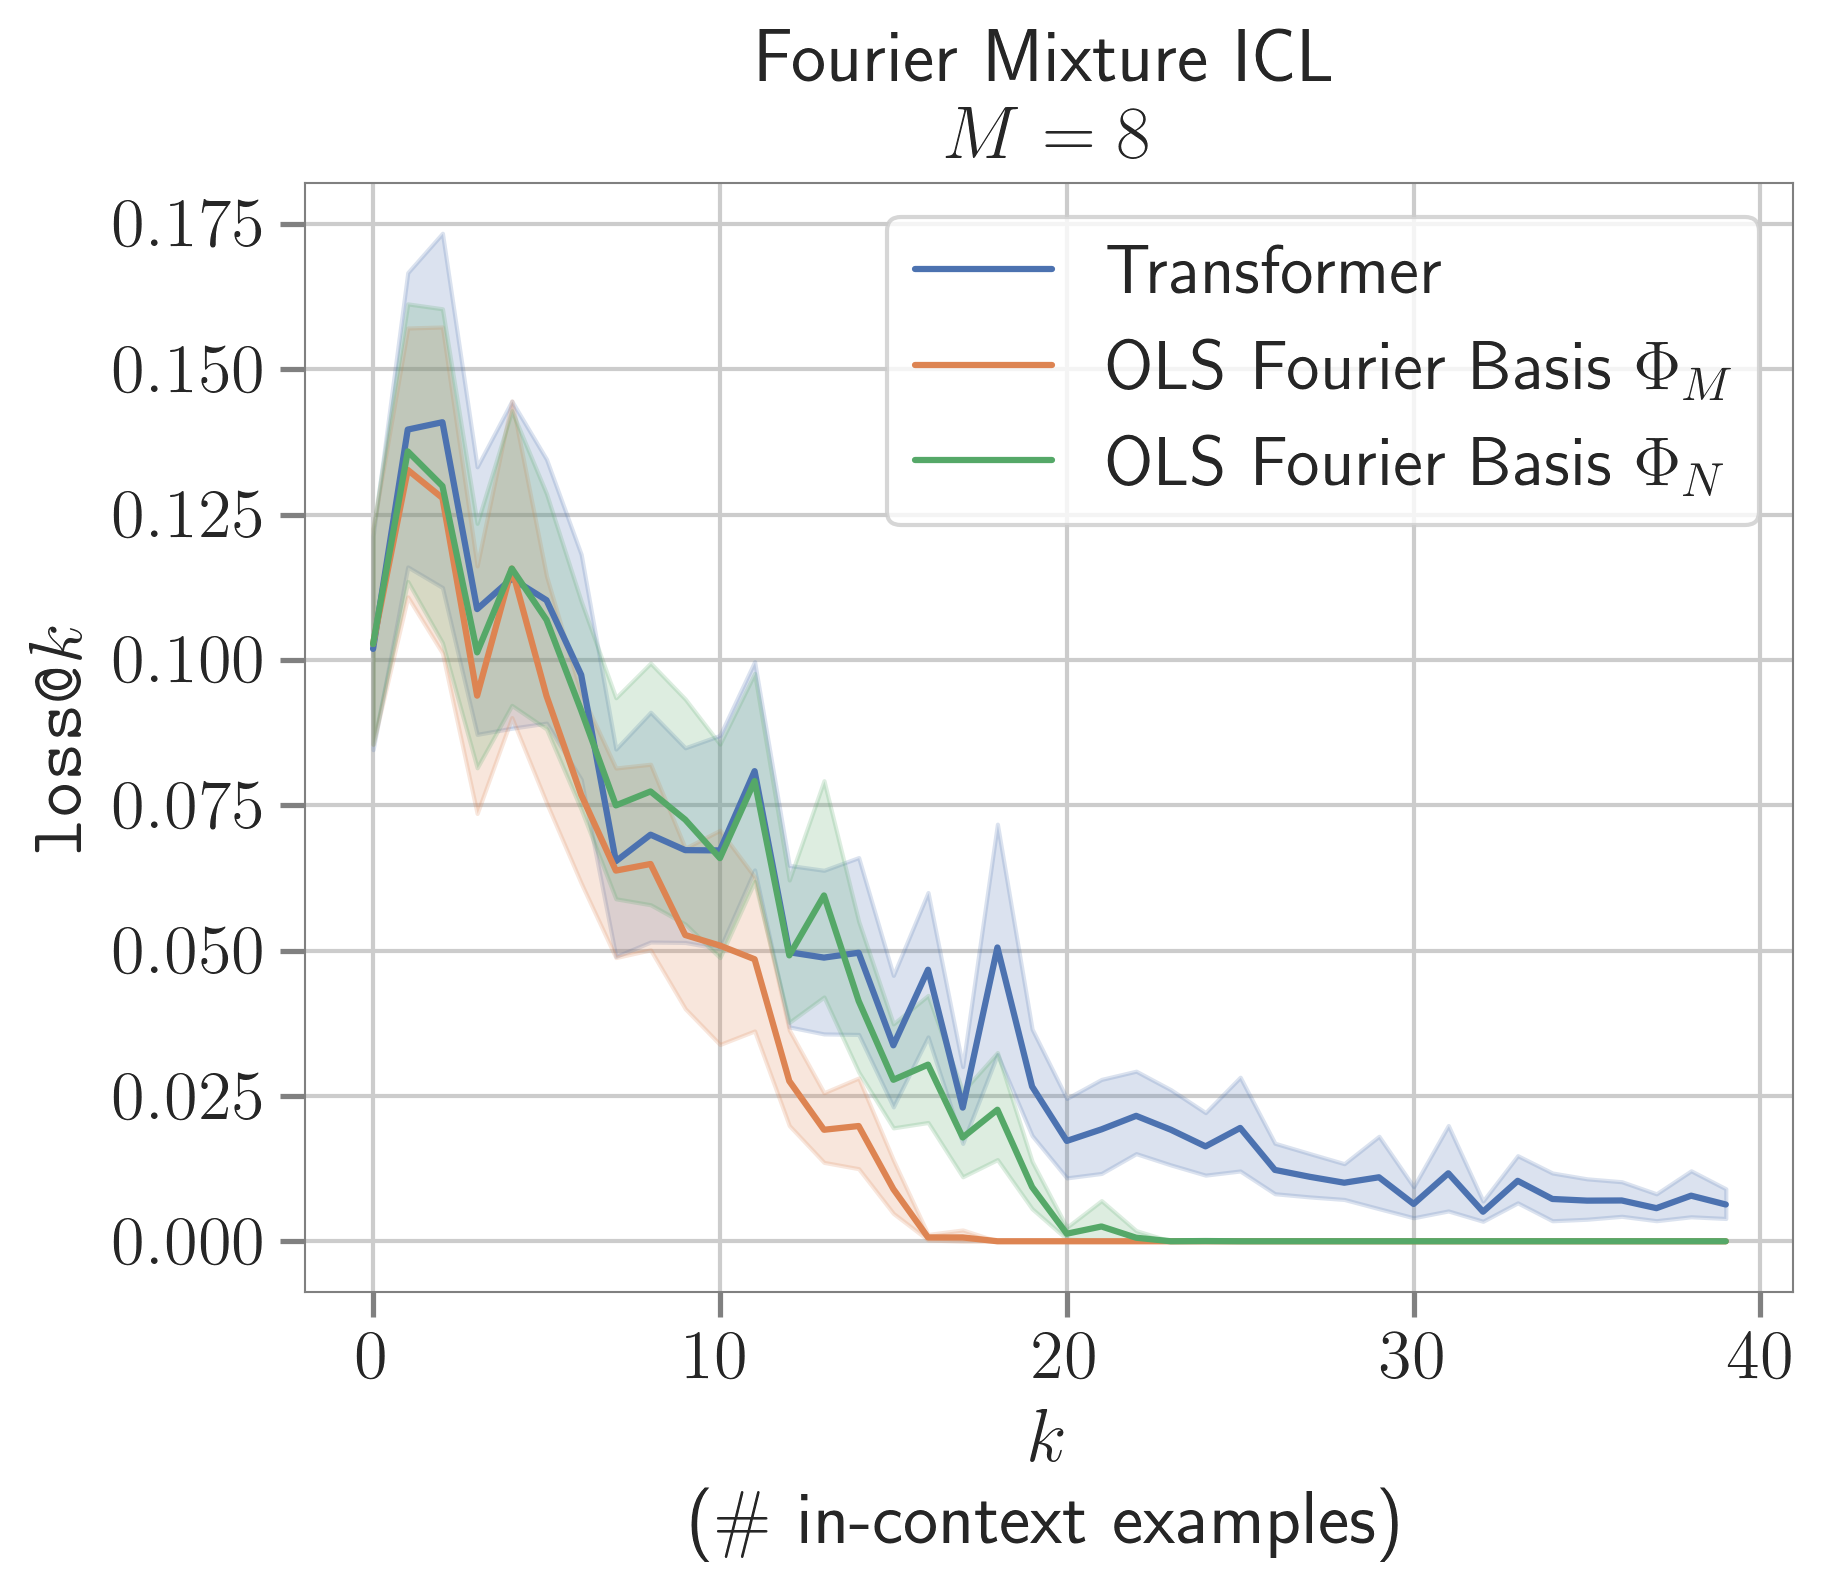

<Figure size 1920x1440 with 0 Axes>

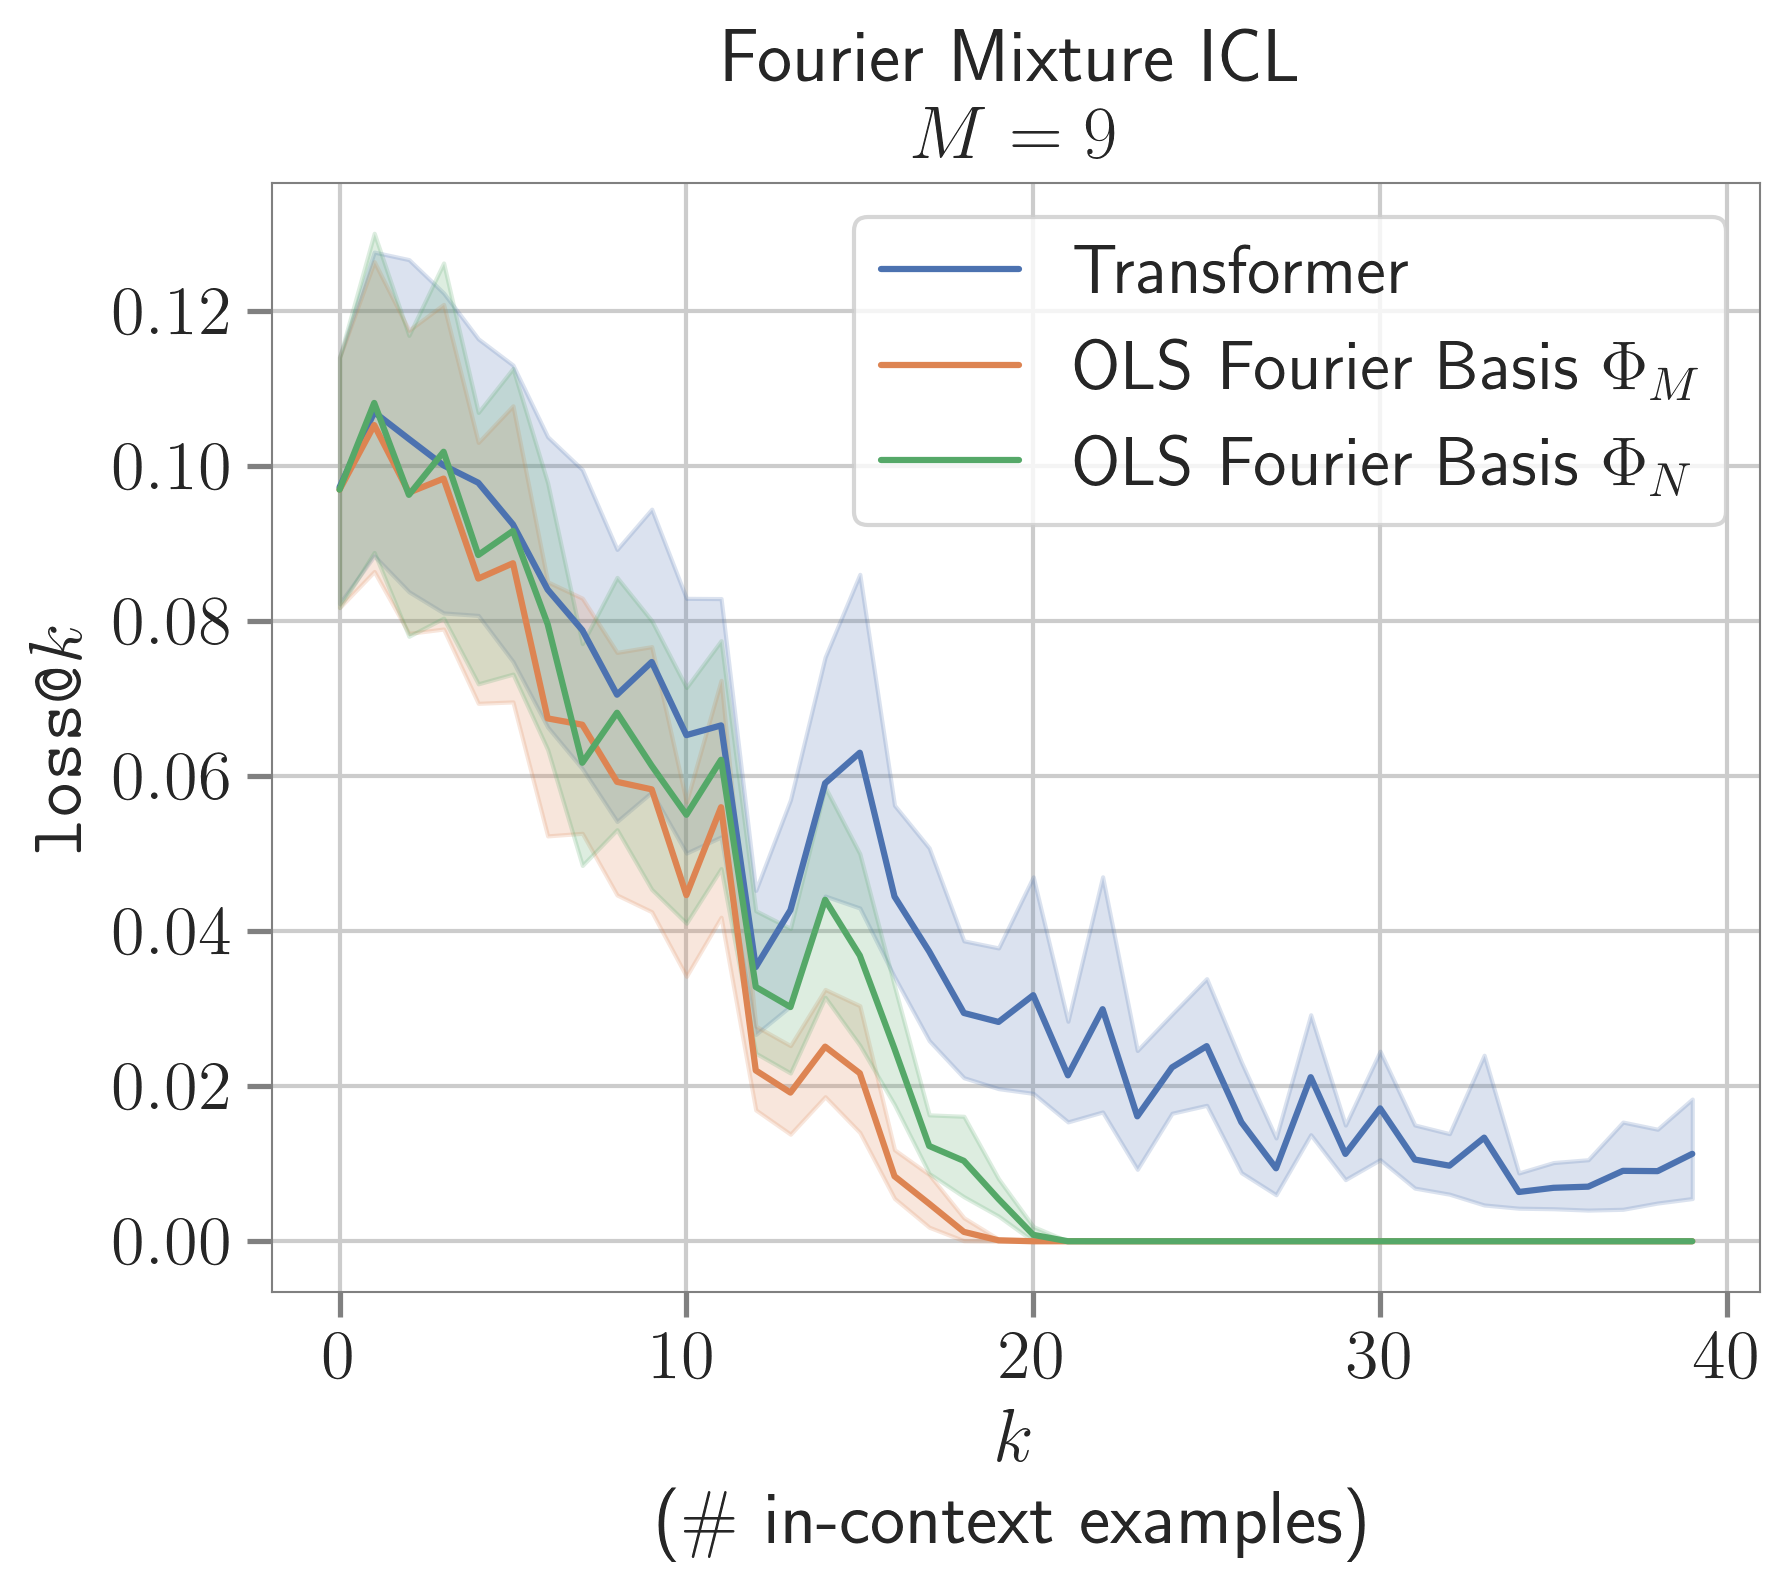

<Figure size 1920x1440 with 0 Axes>

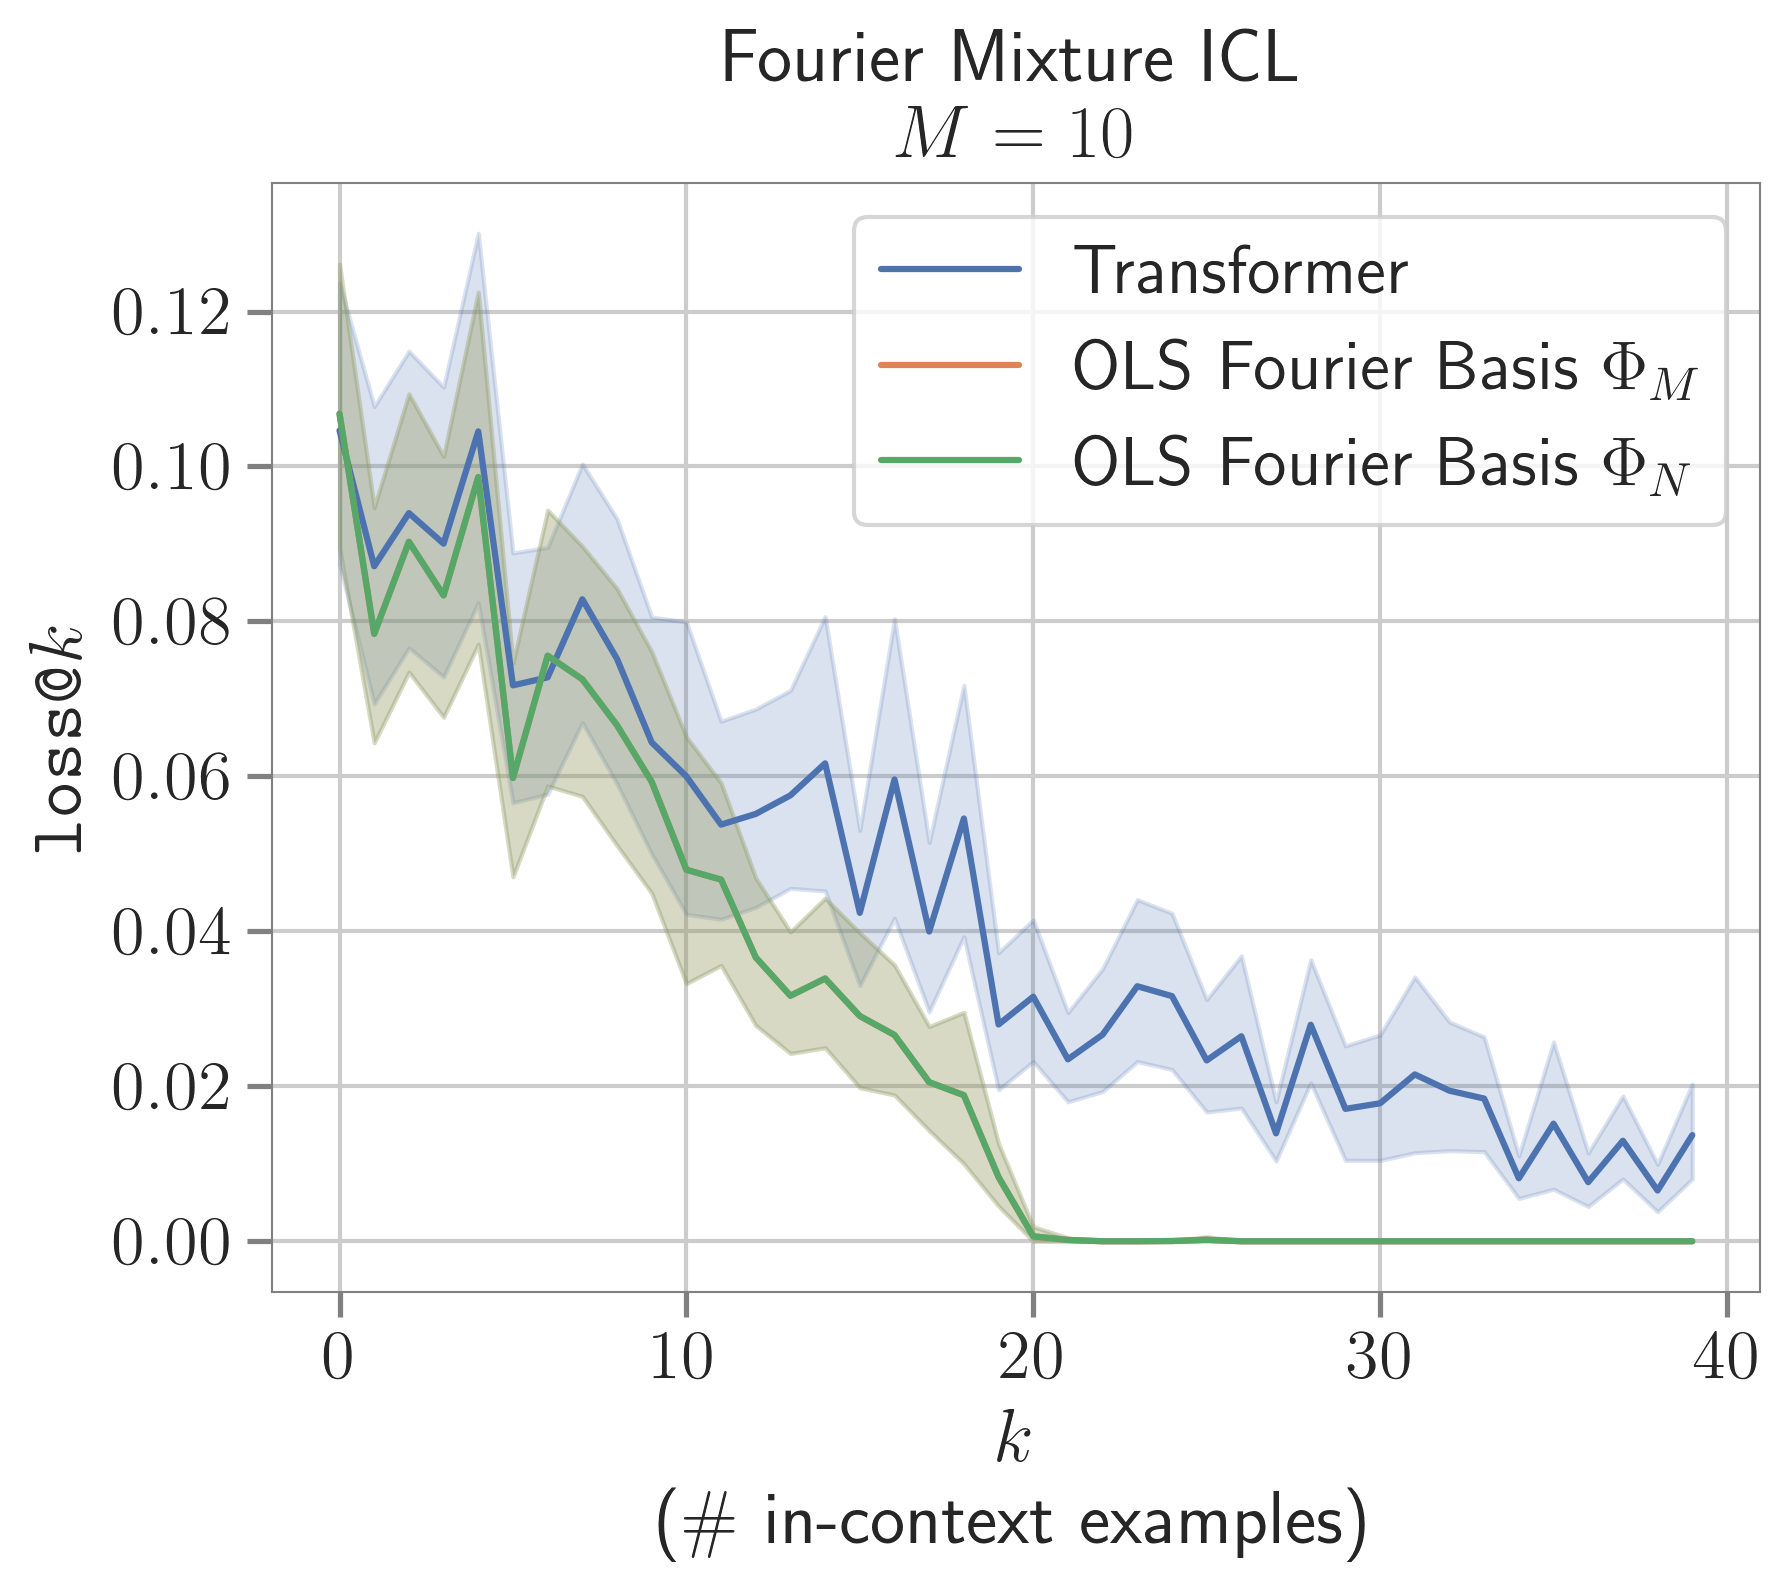

In [77]:
for freq, sq_errors, sq_ffg_errors, sq_ffm_errors in zip(
    range(1, 11), trans_errors_ls, ffg_errors_ls, ffm_errors_ls
):
    sns.set(style="whitegrid", font_scale=1.5)
    seed = 42
    plt.figure()
    fig, ax = plt.subplots()
    # ax.plot(np.arange(1, xs.shape[1]+1), sq_errors_wo_curr, label = "Transformer")
    lineplot_with_ci(
        sq_errors, xs.shape[1], offset=0, label="Transformer", ax=ax, seed=seed
    )
    #     ax.plot(np.arange(xs.shape[1]), sq_errors.mean(0), label = "Transformer")
    # ax.plot(np.arange(xs.shape[1]), torch.cat(ffg_errors_ls[:10]).mean(0), label =  "OLS Fourier Basis $\Phi_{M}$")
    #     ax.plot(np.arange(xs.shape[1]), sq_ffg_errors.mean(0), label =  "OLS Fourier Basis $\Phi_{M}$")
    #     ax.plot(np.arange(xs.shape[1]), sq_ffm_errors.mean(0), label =  "OLS Fourier Basis $\Phi_{N}$")
    lineplot_with_ci(
        sq_ffg_errors,
        xs.shape[1],
        offset=0,
        label="OLS Fourier Basis $\Phi_{M}$",
        ax=ax,
        seed=seed,
    )
    lineplot_with_ci(
        sq_ffm_errors,
        xs.shape[1],
        offset=0,
        label="OLS Fourier Basis $\Phi_{N}$",
        ax=ax,
        seed=seed,
    )
    #     lineplot_with_ci(bma_errors, xs.shape[1], offset = 0,  label = "PME", ax=ax, seed=seed)
    format_axes(ax)
    #     plt.plot(np.arange(1, xs.shape[1]+1), sq_gpr_errors, label = "GPR", marker = "o")
    plt.xlabel("$k$\n(\# in-context examples)")
    plt.ylabel("$\\texttt{loss@}k$")
    plt.title(f"Fourier Mixture ICL\n$M={freq}$")
    # plt.yscale('log')
    plt.legend()
#     plt.ylim(-0.1,1)
#     plt.savefig("final_plots/fourier_eq_errors.pdf", dpi = 300, bbox_inches = "tight")

In [58]:
torch.cat(trans_errors_ls[:10]).shape

torch.Size([640, 40])

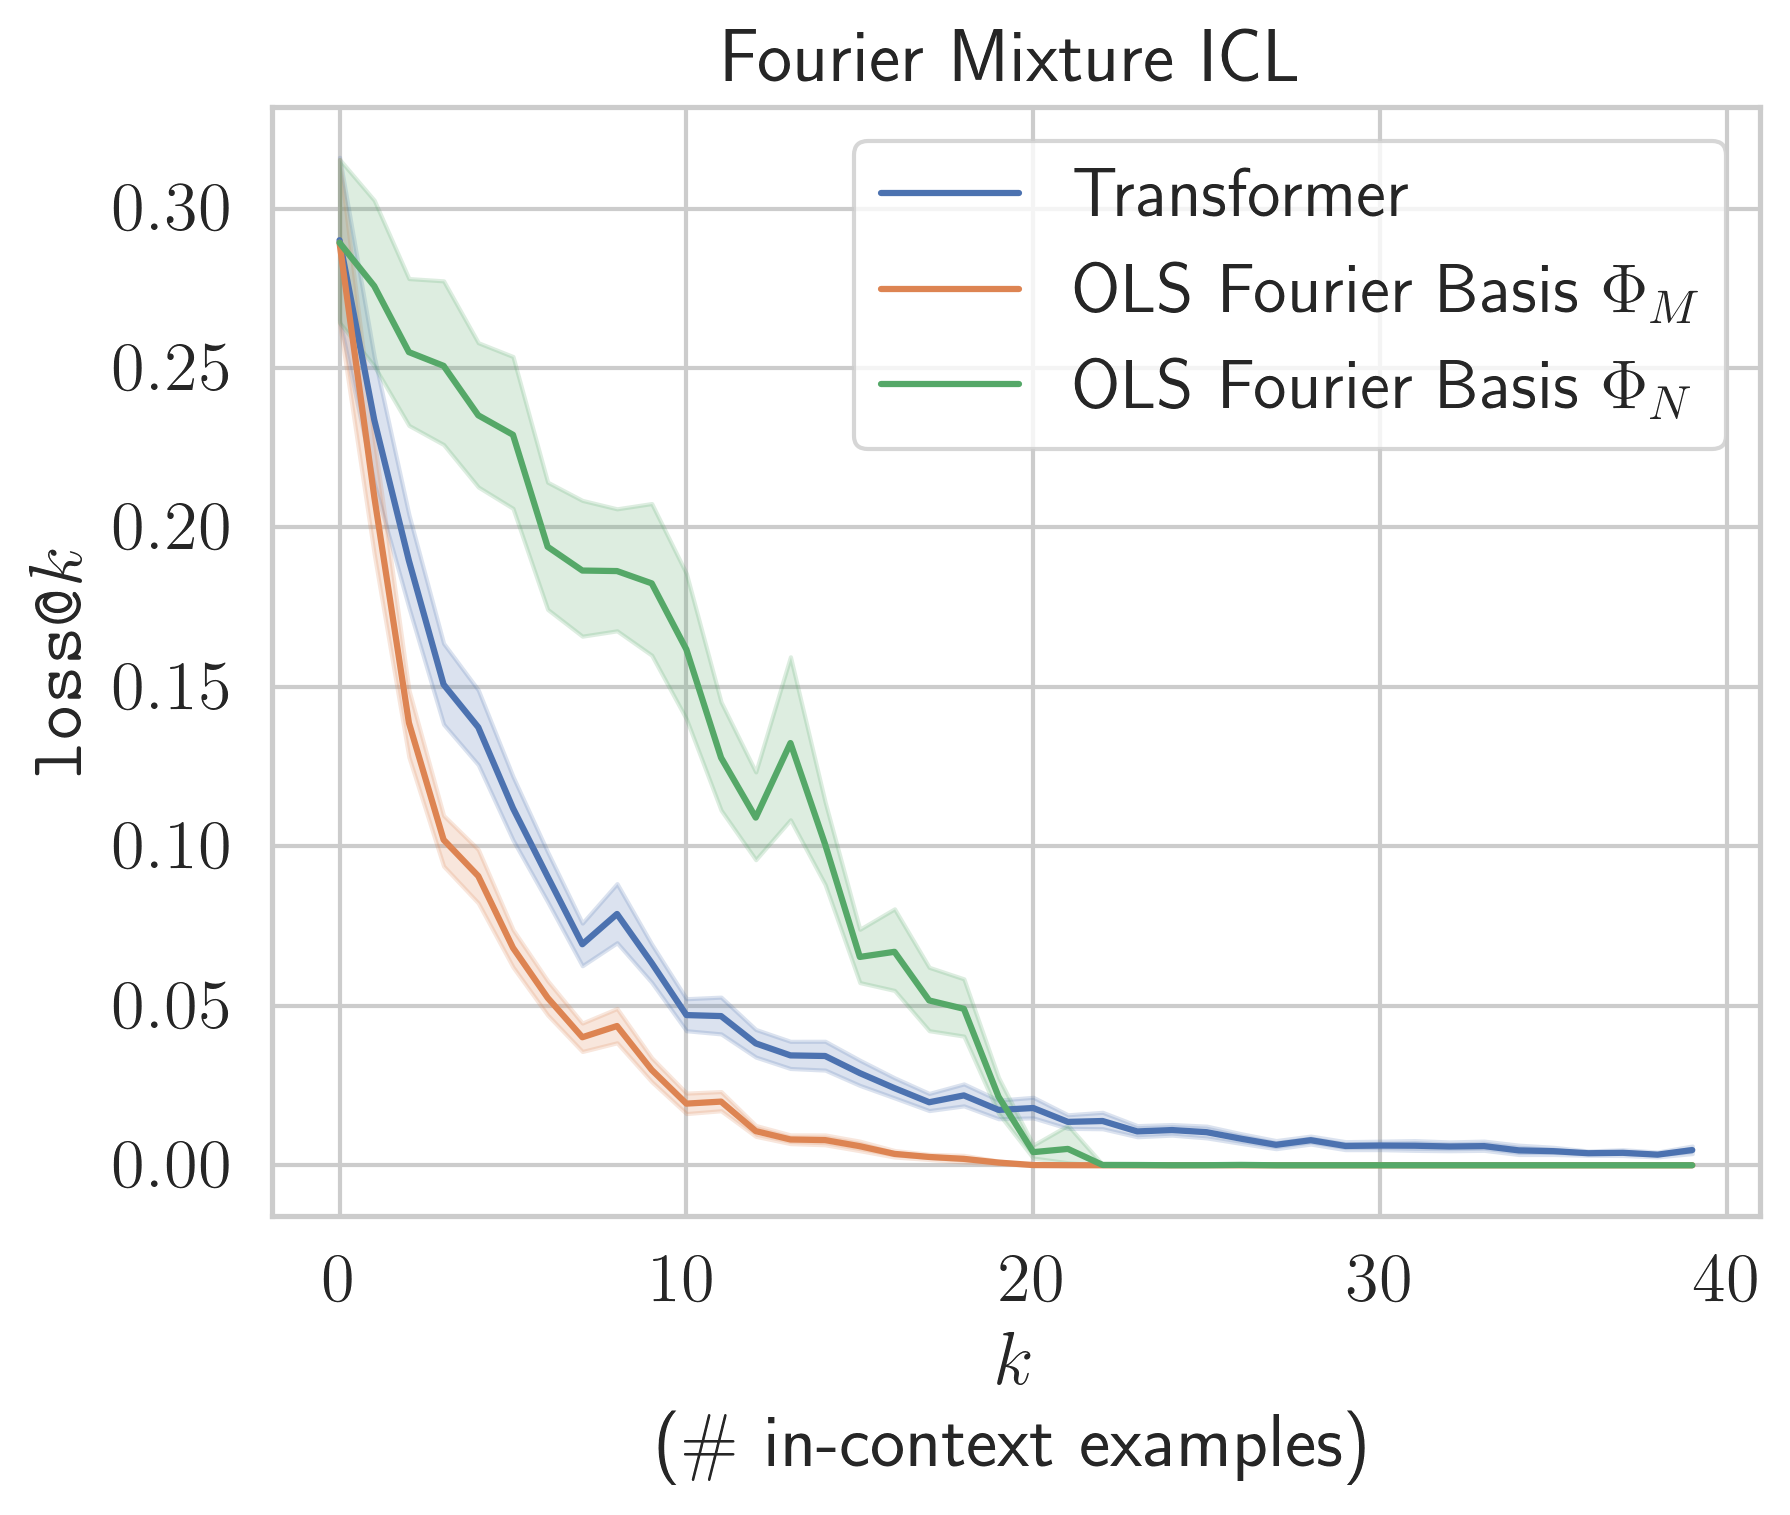

In [78]:
sns.set(style="whitegrid", font_scale=1.5)
fig, ax = plt.subplots()
# ax.plot(np.arange(xs.shape[1]), torch.cat(trans_errors_ls[:10]).mean(0), label = "Transformer")
# ax.plot(np.arange(xs.shape[1]), torch.cat(ffg_errors_ls[:10]).mean(0), label =  "OLS Fourier Basis $\Phi_{M}$")
# ax.plot(np.arange(xs.shape[1]), torch.cat(ffm_errors_ls[:10]).mean(0), label =  "OLS Fourier Basis $\Phi_{M}$")

lineplot_with_ci(
    torch.cat(trans_errors_ls[:10]),
    xs.shape[1],
    offset=0,
    label="Transformer",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(
    torch.cat(ffg_errors_ls[:10]),
    xs.shape[1],
    offset=0,
    label="OLS Fourier Basis $\Phi_{M}$",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(
    torch.cat(ffm_errors_ls[:10]),
    xs.shape[1],
    offset=0,
    label="OLS Fourier Basis $\Phi_{N}$",
    ax=ax,
    seed=seed,
)

plt.xlabel("$k$\n(\# in-context examples)")
plt.ylabel("$\\texttt{loss@}k$")
plt.title(f"Fourier Mixture ICL")
plt.legend()
plt.savefig(f"final_plots/fourier_mix_errors.pdf", dpi=300)

## Function Visualizations

In [79]:
# sns.set(style = "whitegrid", font_scale=1.5)
# torch.manual_seed(seed)
# L = 5
# prompt_len = 2
# n = 40
# batch_size = 1
# max_freq = 10
# xs = data_sampler.sample_xs(b_size=batch_size, n_points=n)
# task_sampler = get_task_sampler(
#         conf.training.task,
#         n_dims,
#         batch_size,
#         **conf.training.task_kwargs
#     )
# task = task_sampler()
# ys = task.evaluate(xs)

# y_preds = []
# x_cont = torch.linspace(-L, L,n).unsqueeze(0).unsqueeze(-1)
# y_cont = task.evaluate(x_cont)

# y_preds_prefixes = []
# print("Getting Prefix Resuts")

# fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# for pl_idx, pl in tqdm(enumerate([5, 10])):#enumerate(tqdm([0.5] + list(range(1, 21)))):
#     x_prefix = xs[:, :int(2*pl)]
#     y_prefix = ys[:, :int(2*pl)]

#     x_prompt = torch.cat([x_prefix.repeat(x_cont.size(1), 1, 1),x_cont.transpose(1,0)], axis = 1)
#     y_prompt = torch.cat([y_prefix.repeat(y_cont.size(1), 1), y_cont.transpose(1,0)], axis = 1)

#     print("Predicting For Transformer")
#     with torch.no_grad():
#         if pl != 0:
#             y_preds_trans = model_w_curr(x_prompt.to("cuda"), y_prompt.to("cuda")).squeeze()[:, -1].cpu()
#         else:
#             y_preds_trans = model_w_curr(x_prompt.to("cuda"), y_prompt.to("cuda")).squeeze().cpu()

#     y_preds_trans = y_preds_trans.detach().cpu().numpy()

#     print("Predicting for Fourier OLS")
#     x_fourier_prefix = FourierFeatures(max_freq=conf.training.task_kwargs["max_frequency"], L=L).transform(x_prefix).squeeze(0).numpy()
#     x_fourier_cont = FourierFeatures(max_freq=conf.training.task_kwargs["max_frequency"], L=L).transform(x_cont).squeeze(0).numpy()
#     lsq_model = LinearRegression(fit_intercept=False)
#     lsq_model.fit(
#                 x_fourier_prefix,
#                 y_prefix.numpy().squeeze(0)
#             )
#     y_preds_fols = lsq_model.predict(x_fourier_cont)

#     sns.lineplot(x = x_cont.squeeze(),y =  y_cont.squeeze(), label = "Ground Truth", ax = axs[pl_idx])
#     sns.lineplot(x = x_cont.squeeze(), y=  y_preds_trans, label = "Transformer Prediction", ax = axs[pl_idx])
#     sns.lineplot(x = x_cont.squeeze(), y = y_preds_fols, label = "OLS Fourier Prediction", ax = axs[pl_idx])
#     sns.scatterplot(x = x_prefix.squeeze(0).squeeze(-1), y = y_prefix.squeeze(0), label = "Prompt", ax = axs[pl_idx])
#     axs[pl_idx].set_title(f"$k = {2*pl}$")
#     axs[pl_idx].set_xlabel(f"$x$")
#     axs[pl_idx].set_ylabel(f"$f(x)$")

# for ax in axs:
#     ax.legend().set_visible(False)

# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.suptitle(f"$M = {max_freq}$",fontsize=32)
# plt.savefig("final_plots/fourier_eq_func_vis.pdf", dpi = 300, bbox_inches = "tight")

## Inductive Biases

Getting Prefix Resuts
Getting Prefix Resuts


0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.90it/s]
1it [00:00,  4.51it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 76.79it/s]
2it [00:00,  4.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 76.16it/s]
3it [00:00,  4.62it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.81it/s]
4it [00:00,  4.58it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.76it/s]
5it [00:01,  4.50it/s]
100%|██████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.61it/s]
4it [00:01,  3.72it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.86it/s]
5it [00:01,  3.98it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.83it/s]
6it [00:01,  4.17it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.14it/s]
7it [00:01,  3.71it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.61it/s]
1it [00:00,  4.56it/s]
100%|██████████████████████████████████████████████

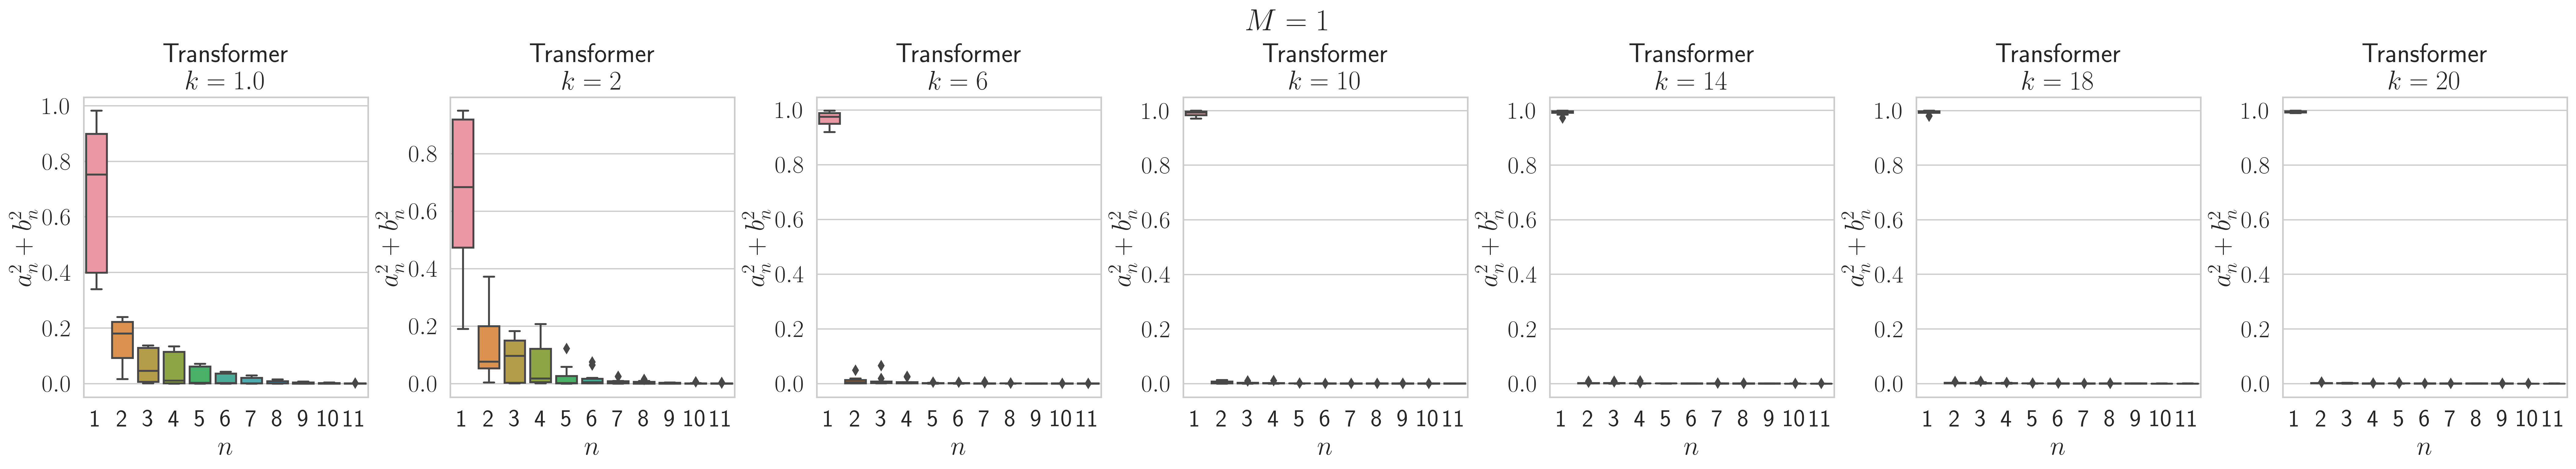

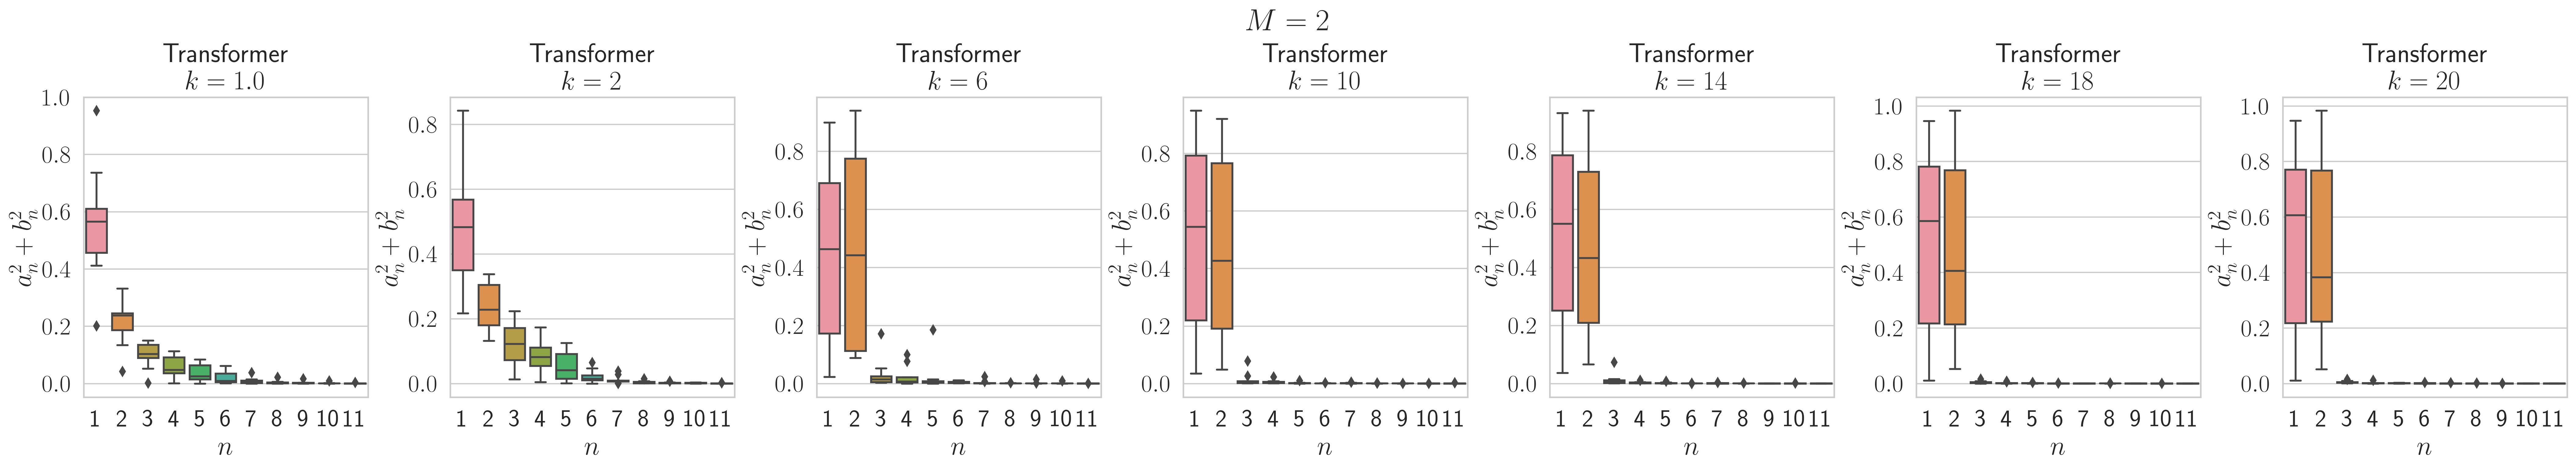

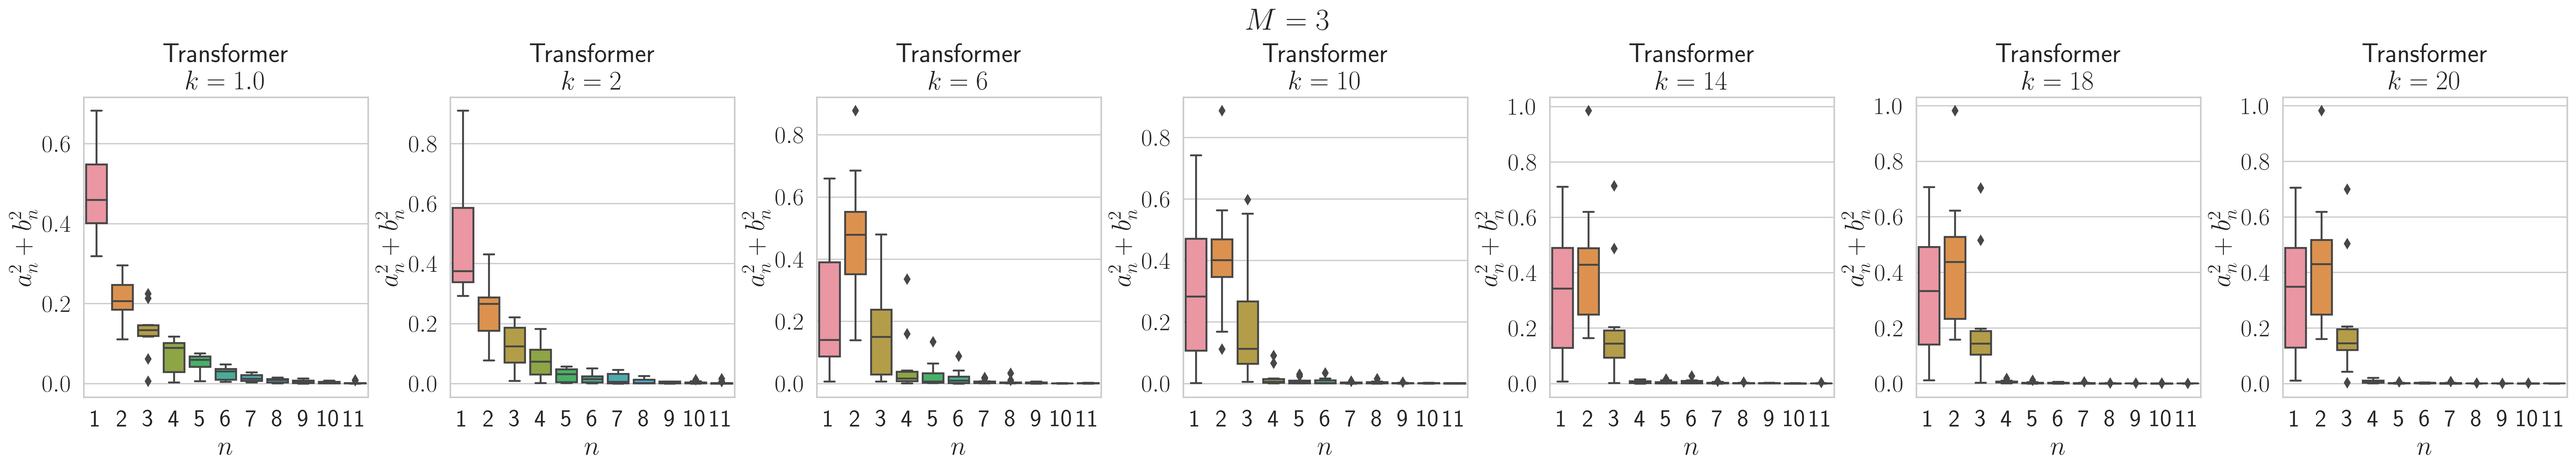

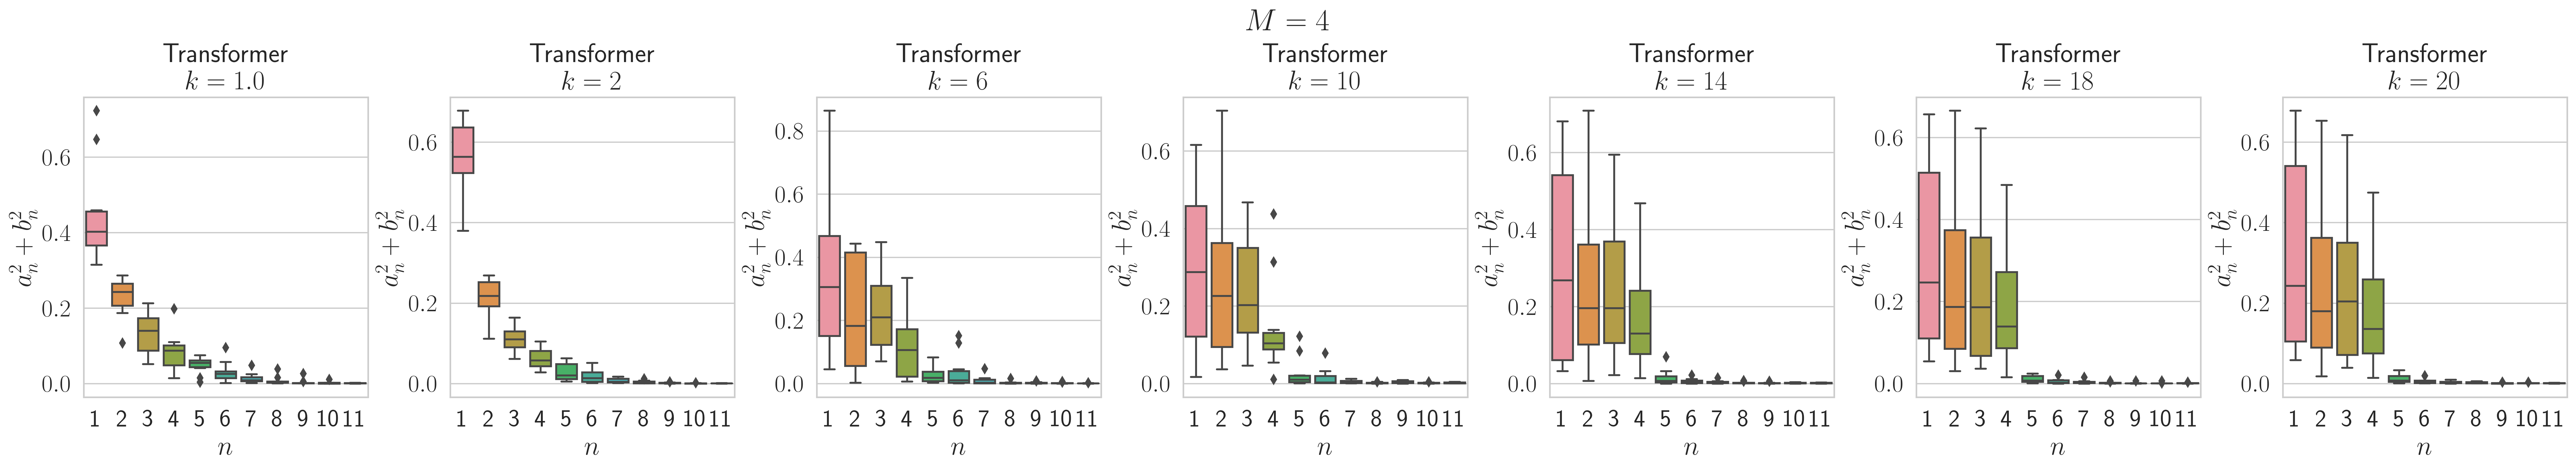

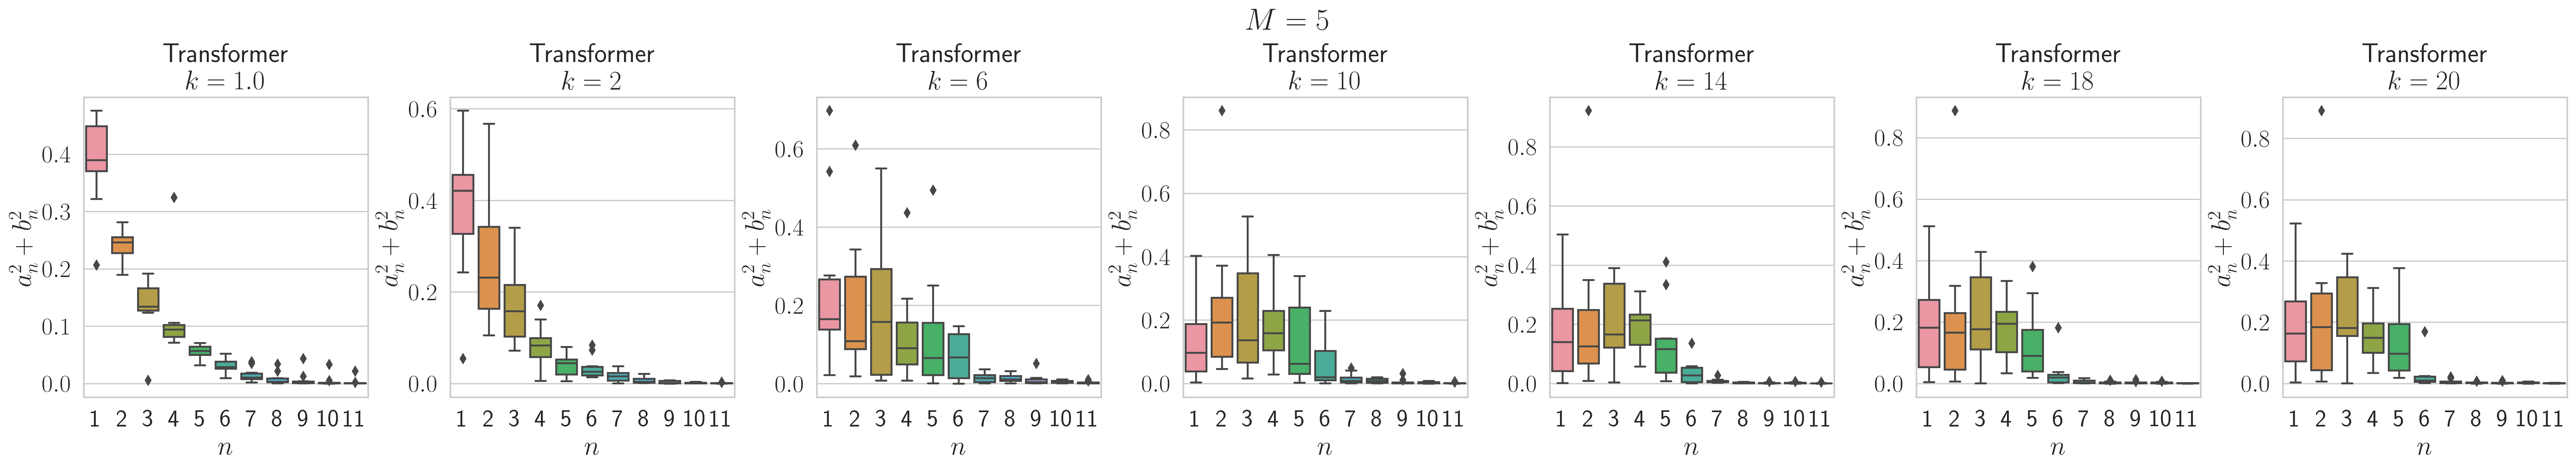

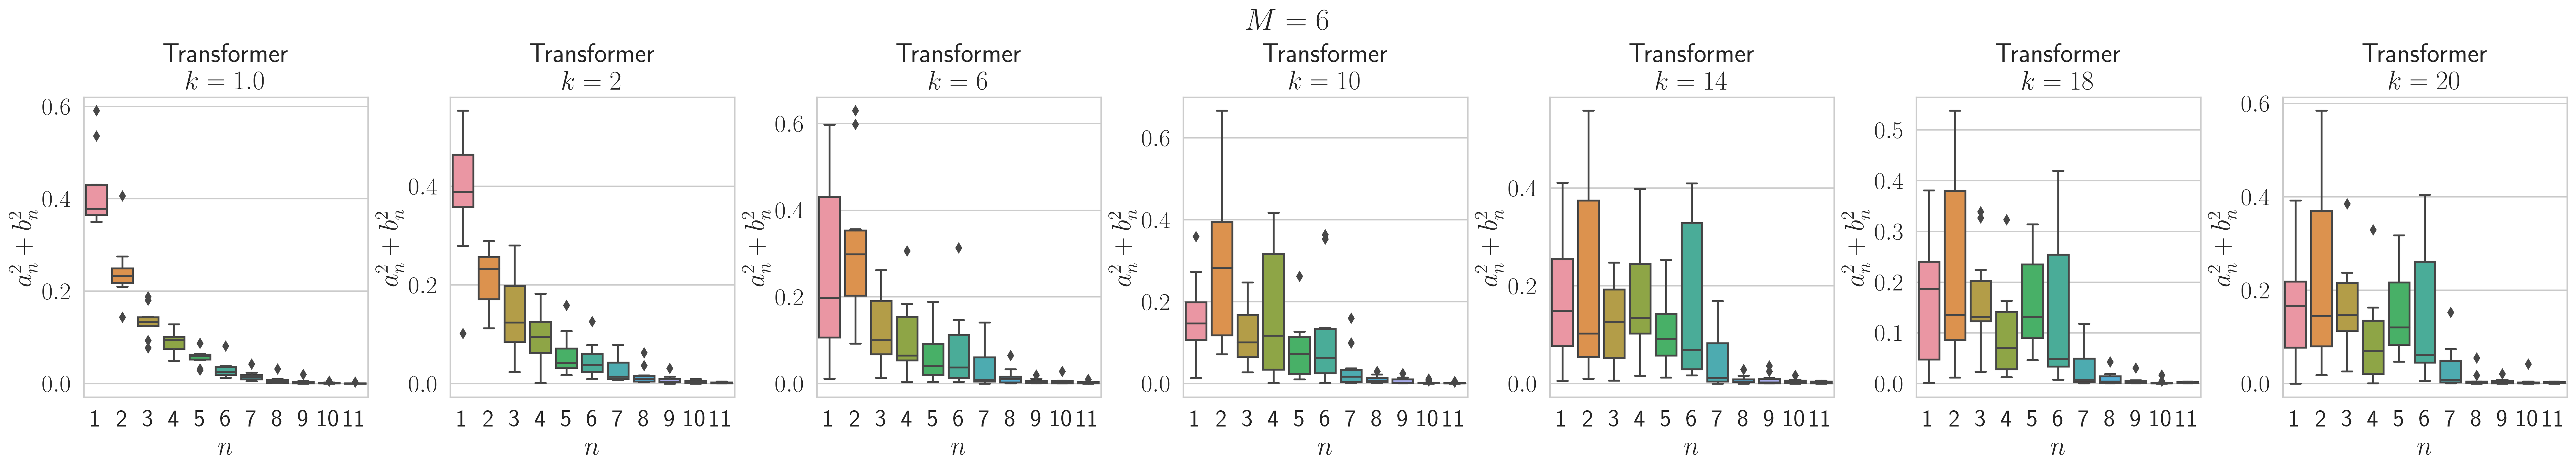

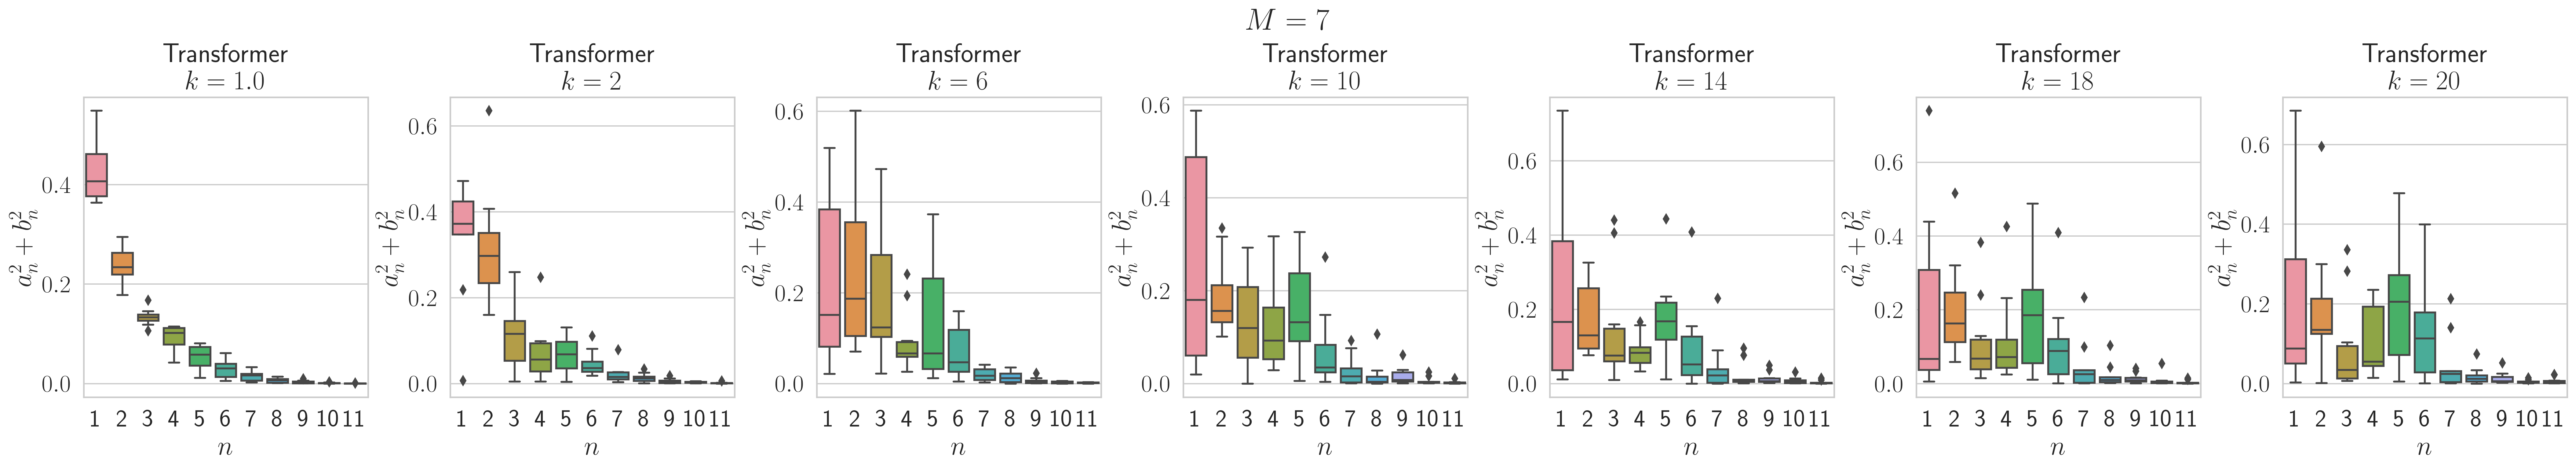

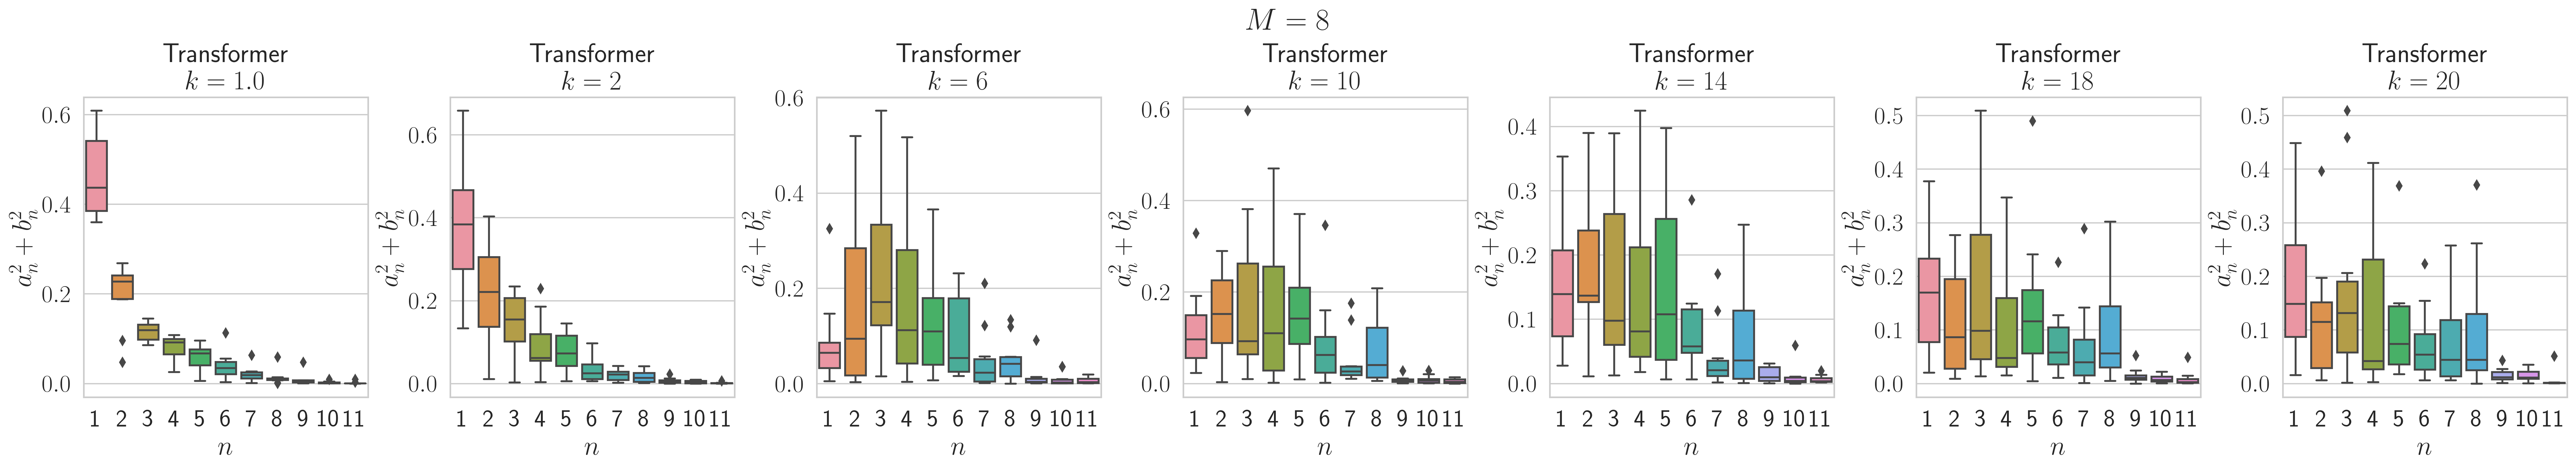

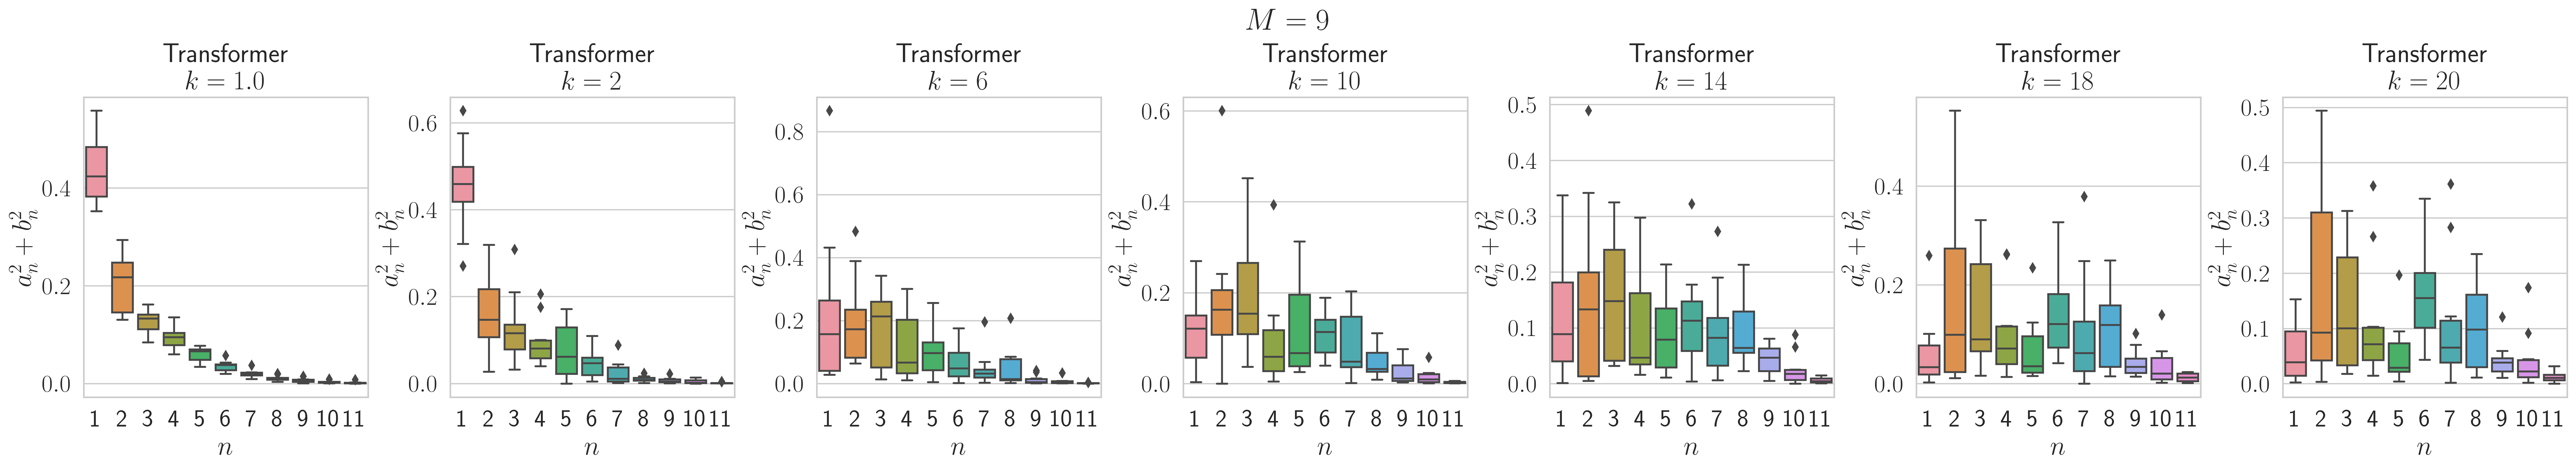

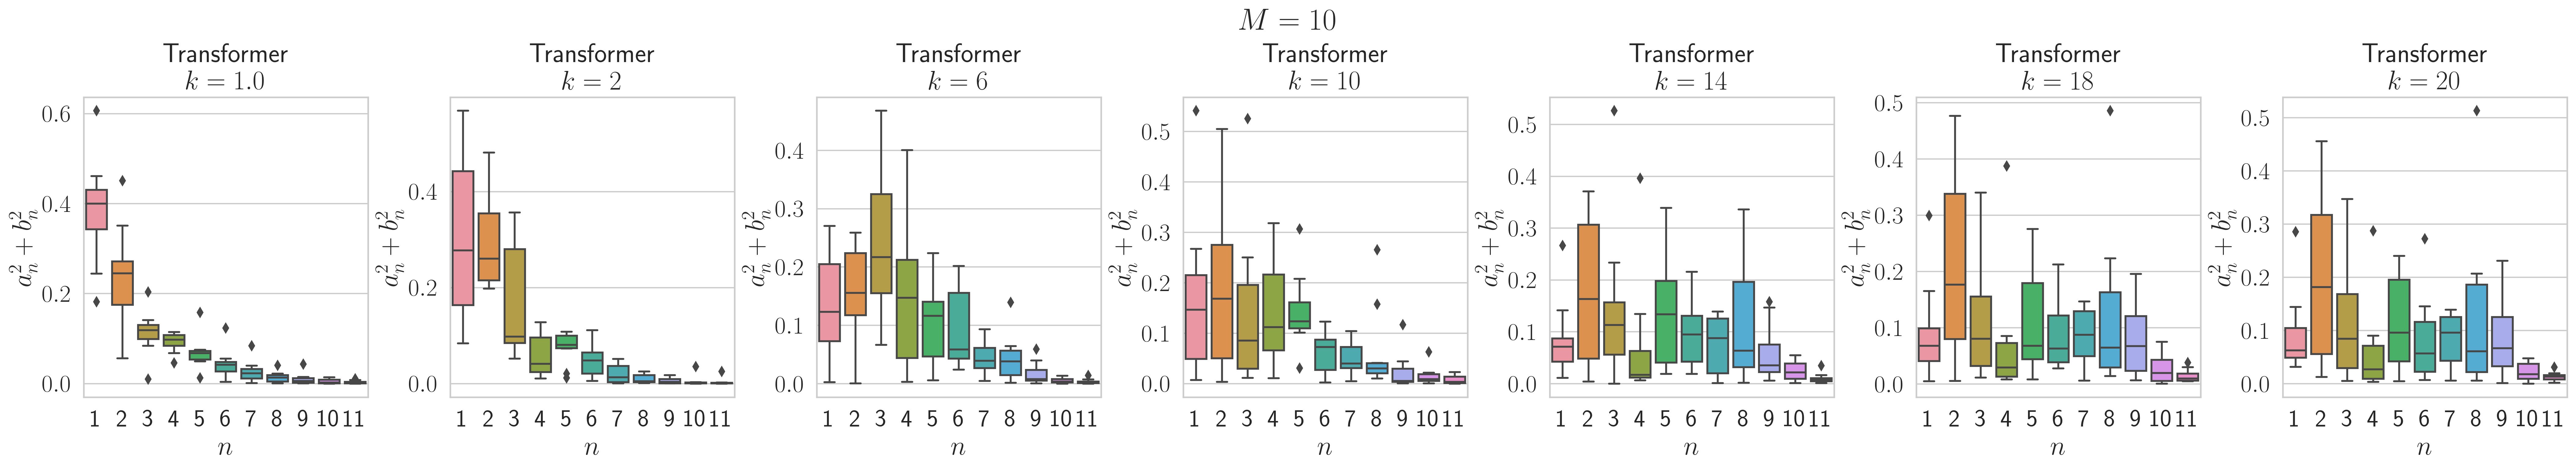

In [19]:
sns.set(style="whitegrid", font_scale=1.75)
seed = 42
torch.manual_seed(seed)

save_dir = "final_plots/inductive_bias_mixture/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


L = 5
prompt_len = 2
n = 24
batch_size = 1
min_freq = 1
max_freq = 4
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n)
task_sampler = get_task_sampler(
    conf.training.task, n_dims, batch_size, **conf.training.task_kwargs
)
task = task_sampler()
ys = task.evaluate(xs)

y_preds = []
x_cont = torch.linspace(-L, L, n).unsqueeze(0).unsqueeze(-1)
y_cont = task.evaluate(x_cont)

y_preds_prefixes = []
print("Getting Prefix Resuts")

print("Getting Prefix Resuts")
for max_freq in range(1, 11):
    torch.manual_seed(seed)
    task = FourierSeries(
        1, 1, max_frequency=max_freq, min_frequency=min_freq, standardize=True, L=L
    )
    ys = task.evaluate(xs)
    y_cont = task.evaluate(x_cont)

    pls = [0.5] + list(range(1, 11, 2)) + [10]
    fig, axs = plt.subplots(
        1, len(pls), figsize=(4 * len(pls), 5), constrained_layout=True
    )

    for pl_idx, pl in tqdm(enumerate(pls)):
        for m_idx, model_type in enumerate(
            ["Transformer"]
        ):  # enumerate(["Transformer", "OLS Fourier Basis"]):
            freq_dist = []
            seed_ls = []
            freqs_ls = []
            for seed in tqdm([1, 11, 22, 33, 44, 55, 66, 77, 88, 99]):
                torch.manual_seed(seed)
                task = FourierSeries(
                    1,
                    batch_size,
                    min_frequency=max_freq,
                    max_frequency=max_freq,
                    standardize=True,
                    L=L,
                )
                xs = data_sampler.sample_xs(b_size=1, n_points=n)
                ys = task.evaluate(xs)
                y_cont = task.evaluate(x_cont)

                x_prefix = xs[:, : int(2 * pl)]
                y_prefix = ys[:, : int(2 * pl)]

                y_preds = []

                x_prompt = torch.cat(
                    [x_prefix.repeat(x_cont.size(1), 1, 1), x_cont.transpose(1, 0)],
                    axis=1,
                )
                y_prompt = torch.cat(
                    [y_prefix.repeat(y_cont.size(1), 1), y_cont.transpose(1, 0)], axis=1
                )

                if "Transformer" in model_type:
                    with torch.no_grad():
                        if pl != 0:
                            y_preds = (
                                model(x_prompt.to("cuda"), y_prompt.to("cuda"))
                                .squeeze()[:, -1]
                                .cpu()
                            )
                        else:
                            y_preds = (
                                model(x_prompt.to("cuda"), y_prompt.to("cuda"))
                                .squeeze()
                                .cpu()
                            )

                    y_preds = y_preds.detach().cpu().numpy()

                elif model_type == "OLS Fourier Basis":
                    lsq_model = LinearRegression(fit_intercept=False)
                    x_fourier_prefix = (
                        FourierFeatures(
                            max_freq=conf.training.task_kwargs["max_frequency"], L=L
                        )
                        .transform(x_prefix)
                        .squeeze(0)
                        .numpy()
                    )
                    x_fourier_cont = (
                        FourierFeatures(
                            max_freq=conf.training.task_kwargs["max_frequency"], L=L
                        )
                        .transform(x_cont)
                        .squeeze(0)
                        .numpy()
                    )
                    lsq_model.fit(x_fourier_prefix, y_prefix.numpy().squeeze(0))
                    y_preds = lsq_model.predict(x_fourier_cont)

                y_fourier = y_preds.squeeze()
                ft = np.fft.fft(y_fourier)
                ft_shifted = np.fft.fftshift(ft)
                ft_normalized = ft_shifted / len(y_fourier)
                ft_positive = ft_normalized[1 + len(y_fourier) // 2 :]
                a_coefs = ft_positive.real
                b_coefs = ft_positive.imag
                coefs_normalized = (a_coefs**2 + b_coefs**2) / (
                    (a_coefs**2).sum() + (b_coefs**2).sum()
                )

                freq_coefs = coefs_normalized  # np.maximum(a_coefs, b_coefs)
                freq_dist += freq_coefs.tolist()
                seed_ls += [seed for _ in range(len(freq_coefs))]
                freqs_ls += list(range(1, len(freq_coefs) + 1))

            freq_dist_df = pd.DataFrame(
                {"Seed": seed_ls, "Frequency": freqs_ls, "Coefficient": freq_dist}
            )
            freq_dist_df = freq_dist_df.dropna()
            sns.boxplot(
                data=freq_dist_df, x="Frequency", y="Coefficient", ax=axs[pl_idx]
            )
            axs[pl_idx + m_idx].set_title(f"{model_type}\n$k = {2*pl}$")
            axs[pl_idx + m_idx].set_xlabel("$n$")
            axs[pl_idx + m_idx].set_ylabel("$a_n^2 + b_n^2$")

    plt.suptitle(f"$M = {max_freq}$", fontsize=24)
    # fig.tight_layout()
    plt.savefig(
        f"{save_dir}/fourier_mix_ib_M{max_freq}.pdf", dpi=300, bbox_inches="tight"
    )

Getting Prefix Resuts


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.37it/s]
1it [00:00,  3.68it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.10it/s]
2it [00:00,  3.55it/s]


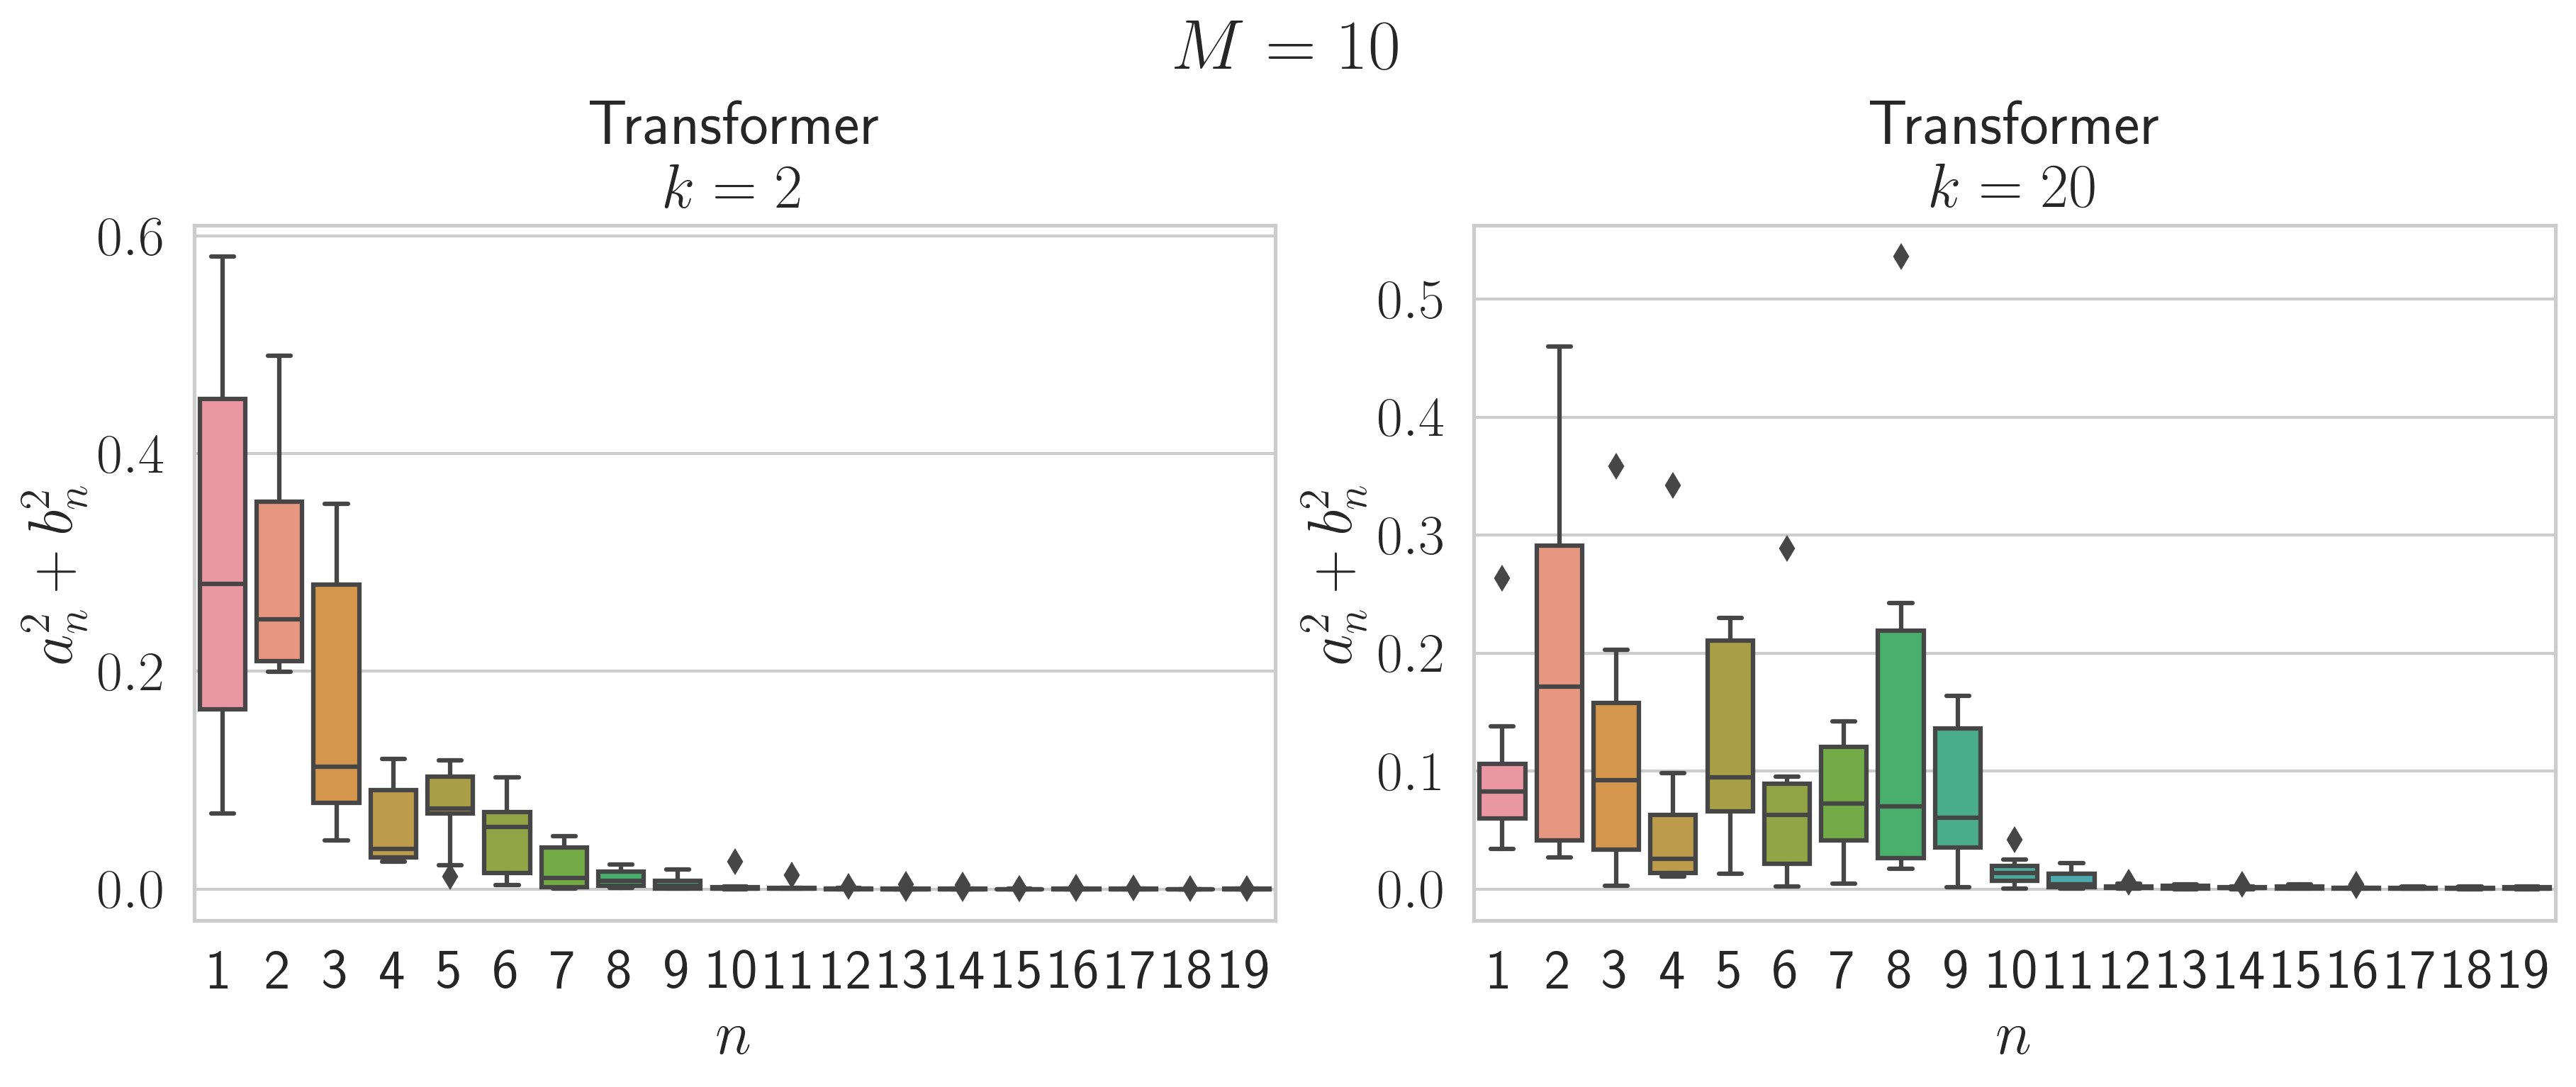

In [88]:
sns.set(style="whitegrid", font_scale=1.75)
torch.manual_seed(seed)
L = 5
prompt_len = 2
n = 40
batch_size = 1
min_freq = 1
max_freq = 10
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n)
task_sampler = get_task_sampler(
    conf.training.task, n_dims, batch_size, **conf.training.task_kwargs
)
task = task_sampler()
ys = task.evaluate(xs)

y_preds = []
x_cont = torch.linspace(-L, L, n).unsqueeze(0).unsqueeze(-1)
y_cont = task.evaluate(x_cont)

y_preds_prefixes = []
print("Getting Prefix Resuts")

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for pl_idx, pl in tqdm(enumerate([1, 10])):
    for m_idx, model_type in enumerate(
        ["Transformer"]
    ):  # enumerate(["Transformer", "OLS Fourier Basis"]):
        freq_dist = []
        seed_ls = []
        freqs_ls = []
        for seed in tqdm([1, 11, 22, 33, 44, 55, 66, 77, 88, 99]):
            torch.manual_seed(seed)
            task = FourierSeries(
                1,
                batch_size,
                min_frequency=max_freq,
                max_frequency=max_freq,
                standardize=True,
                L=L,
            )
            xs = data_sampler.sample_xs(b_size=1, n_points=n)
            ys = task.evaluate(xs)
            y_cont = task.evaluate(x_cont)

            x_prefix = xs[:, : int(2 * pl)]
            y_prefix = ys[:, : int(2 * pl)]

            y_preds = []

            x_prompt = torch.cat(
                [x_prefix.repeat(x_cont.size(1), 1, 1), x_cont.transpose(1, 0)], axis=1
            )
            y_prompt = torch.cat(
                [y_prefix.repeat(y_cont.size(1), 1), y_cont.transpose(1, 0)], axis=1
            )

            if "Transformer" in model_type:
                with torch.no_grad():
                    if pl != 0:
                        y_preds = (
                            model(x_prompt.to("cuda"), y_prompt.to("cuda"))
                            .squeeze()[:, -1]
                            .cpu()
                        )
                    else:
                        y_preds = (
                            model(x_prompt.to("cuda"), y_prompt.to("cuda"))
                            .squeeze()
                            .cpu()
                        )

                y_preds = y_preds.detach().cpu().numpy()

            elif model_type == "OLS Fourier Basis":
                lsq_model = LinearRegression(fit_intercept=False)
                x_fourier_prefix = (
                    FourierFeatures(
                        max_freq=conf.training.task_kwargs["max_frequency"], L=L
                    )
                    .transform(x_prefix)
                    .squeeze(0)
                    .numpy()
                )
                x_fourier_cont = (
                    FourierFeatures(
                        max_freq=conf.training.task_kwargs["max_frequency"], L=L
                    )
                    .transform(x_cont)
                    .squeeze(0)
                    .numpy()
                )
                lsq_model.fit(x_fourier_prefix, y_prefix.numpy().squeeze(0))
                y_preds = lsq_model.predict(x_fourier_cont)

            y_fourier = y_preds.squeeze()
            ft = np.fft.fft(y_fourier)
            ft_shifted = np.fft.fftshift(ft)
            ft_normalized = ft_shifted / len(y_fourier)
            ft_positive = ft_normalized[1 + len(y_fourier) // 2 :]
            a_coefs = ft_positive.real
            b_coefs = ft_positive.imag
            coefs_normalized = (a_coefs**2 + b_coefs**2) / (
                (a_coefs**2).sum() + (b_coefs**2).sum()
            )

            freq_coefs = coefs_normalized  # np.maximum(a_coefs, b_coefs)
            freq_dist += freq_coefs.tolist()
            seed_ls += [seed for _ in range(len(freq_coefs))]
            freqs_ls += list(range(1, len(freq_coefs) + 1))

        freq_dist_df = pd.DataFrame(
            {"Seed": seed_ls, "Frequency": freqs_ls, "Coefficient": freq_dist}
        )
        freq_dist_df = freq_dist_df.dropna()
        sns.boxplot(data=freq_dist_df, x="Frequency", y="Coefficient", ax=axs[pl_idx])
        axs[pl_idx + m_idx].set_title(f"{model_type}\n$k = {2*pl}$")
        axs[pl_idx + m_idx].set_xlabel("$n$")
        axs[pl_idx + m_idx].set_ylabel("$a_n^2 + b_n^2$")

plt.suptitle(f"$M = {max_freq}$", fontsize=24)
# fig.tight_layout()
plt.savefig("final_plots/fourier_mix_ib_v2.pdf", dpi=300, bbox_inches="tight")

Getting Prefix Resuts


0it [00:00, ?it/s]
0it [00:00, ?it/s]

  0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.31it/s]

1it [00:00,  3.54it/s]

  0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.19it/s]

2it [00:00,  3.43it/s]
1it [00:00,  1.71it/s]
0it [00:00, ?it/s]

  0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.14it/s]

1it [00:00,  

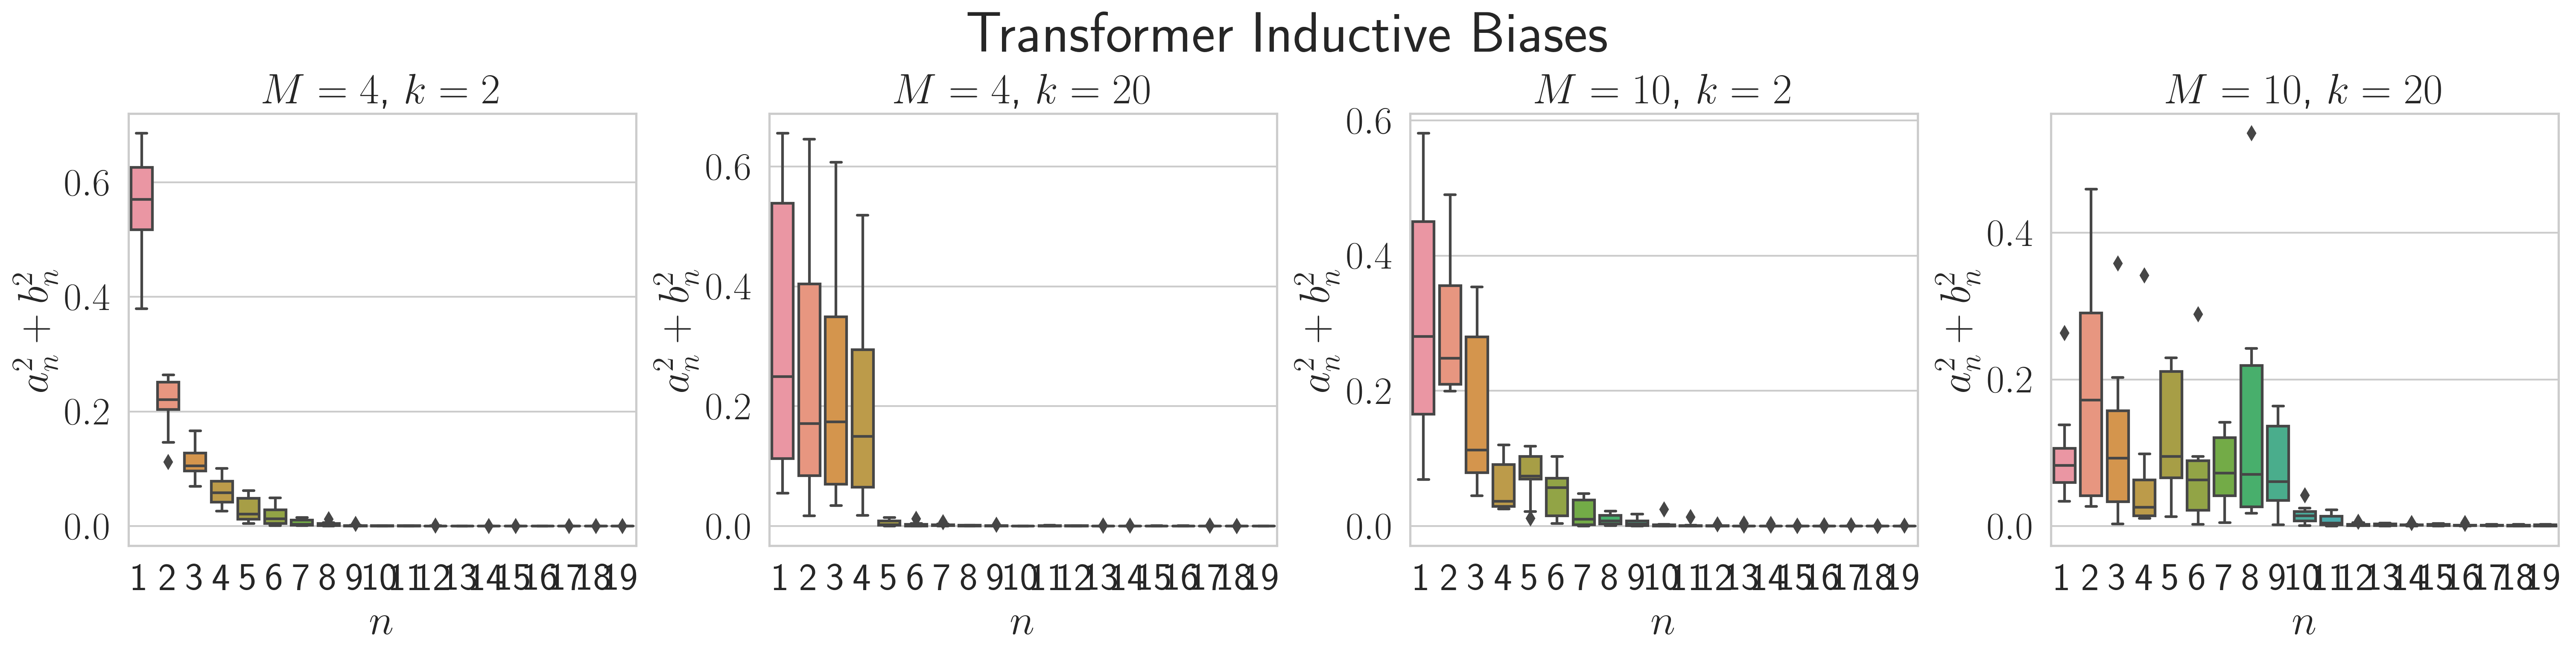

In [93]:
sns.set(style="whitegrid", font_scale=2)
torch.manual_seed(seed)
L = 5
prompt_len = 2
n = 40
batch_size = 1
min_freq = 1
max_freq = 10
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n)
task_sampler = get_task_sampler(
    conf.training.task, n_dims, batch_size, **conf.training.task_kwargs
)
task = task_sampler()
ys = task.evaluate(xs)

y_preds = []
x_cont = torch.linspace(-L, L, n).unsqueeze(0).unsqueeze(-1)
y_cont = task.evaluate(x_cont)

y_preds_prefixes = []
print("Getting Prefix Resuts")
model_type = "Transformer"
fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

for m_idx, max_freq in tqdm(enumerate([4, 10])):
    for pl_idx, pl in tqdm(enumerate([1, 10])):
        freq_dist = []
        seed_ls = []
        freqs_ls = []
        for seed in tqdm([1, 11, 22, 33, 44, 55, 66, 77, 88, 99]):
            torch.manual_seed(seed)
            task = FourierSeries(
                1,
                batch_size,
                min_frequency=max_freq,
                max_frequency=max_freq,
                standardize=True,
                L=L,
            )
            xs = data_sampler.sample_xs(b_size=1, n_points=n)
            ys = task.evaluate(xs)
            y_cont = task.evaluate(x_cont)

            x_prefix = xs[:, : int(2 * pl)]
            y_prefix = ys[:, : int(2 * pl)]

            y_preds = []

            x_prompt = torch.cat(
                [x_prefix.repeat(x_cont.size(1), 1, 1), x_cont.transpose(1, 0)], axis=1
            )
            y_prompt = torch.cat(
                [y_prefix.repeat(y_cont.size(1), 1), y_cont.transpose(1, 0)], axis=1
            )

            if "Transformer" in model_type:
                with torch.no_grad():
                    if pl != 0:
                        y_preds = (
                            model(x_prompt.to("cuda"), y_prompt.to("cuda"))
                            .squeeze()[:, -1]
                            .cpu()
                        )
                    else:
                        y_preds = (
                            model(x_prompt.to("cuda"), y_prompt.to("cuda"))
                            .squeeze()
                            .cpu()
                        )

                y_preds = y_preds.detach().cpu().numpy()

            elif model_type == "OLS Fourier Basis":
                lsq_model = LinearRegression(fit_intercept=False)
                x_fourier_prefix = (
                    FourierFeatures(
                        max_freq=conf.training.task_kwargs["max_frequency"], L=L
                    )
                    .transform(x_prefix)
                    .squeeze(0)
                    .numpy()
                )
                x_fourier_cont = (
                    FourierFeatures(
                        max_freq=conf.training.task_kwargs["max_frequency"], L=L
                    )
                    .transform(x_cont)
                    .squeeze(0)
                    .numpy()
                )
                lsq_model.fit(x_fourier_prefix, y_prefix.numpy().squeeze(0))
                y_preds = lsq_model.predict(x_fourier_cont)

            y_fourier = y_preds.squeeze()
            ft = np.fft.fft(y_fourier)
            ft_shifted = np.fft.fftshift(ft)
            ft_normalized = ft_shifted / len(y_fourier)
            ft_positive = ft_normalized[1 + len(y_fourier) // 2 :]
            a_coefs = ft_positive.real
            b_coefs = ft_positive.imag
            coefs_normalized = (a_coefs**2 + b_coefs**2) / (
                (a_coefs**2).sum() + (b_coefs**2).sum()
            )

            freq_coefs = coefs_normalized  # np.maximum(a_coefs, b_coefs)
            freq_dist += freq_coefs.tolist()
            seed_ls += [seed for _ in range(len(freq_coefs))]
            freqs_ls += list(range(1, len(freq_coefs) + 1))

        freq_dist_df = pd.DataFrame(
            {"Seed": seed_ls, "Frequency": freqs_ls, "Coefficient": freq_dist}
        )
        freq_dist_df = freq_dist_df.dropna()
        sns.boxplot(
            data=freq_dist_df,
            x="Frequency",
            y="Coefficient",
            ax=axs[pl_idx + 2 * m_idx],
        )
        axs[pl_idx + 2 * m_idx].set_title(f"$M = {max_freq}$, $k = {2*pl}$")
        axs[pl_idx + 2 * m_idx].set_xlabel("$n$")
        axs[pl_idx + 2 * m_idx].set_ylabel("$a_n^2 + b_n^2$")

# fig.tight_layout()
plt.suptitle(f"Transformer Inductive Biases", fontsize=32)
plt.savefig("final_plots/fourier_mix_ib_v3.pdf", dpi=300, bbox_inches="tight")